In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pdb
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, LogisticRegression

In [4]:
import itertools
from sklearn.model_selection import KFold

In [5]:
sys.path.append('/home/akumar/nse/neural_control')
from utils import apply_df_filters, calc_loadings

### Initial Sabes decoding

In [11]:
with open('/home/akumar/nse/neural_control/data/sabes_decoding_df.dat', 'rb') as f:
    sabes_df = pickle.load(f)

In [12]:
sabes_df.keys()

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'dimreduc_method',
       'dimreduc_args', 'coef', 'score', 'bin_width', 'filter_fn',
       'filter_kwargs', 'boxcox', 'spike_threshold', 'dim_vals', 'n_folds',
       'data_file', 'decoder', 'decoder_args', 'decoder_obj', 'r2'],
      dtype='object')

In [13]:
sabes_df.iloc[0]['decoder_args']

{'trainlag': 4, 'testlag': 4, 'decoding_window': 5}

In [14]:
peanut_files = glob.glob('/mnt/Secondary/data/peanut_dimreduc/peanut_dimreduc_*.dat')

In [32]:
p_l = []
for file_ in peanut_files:
    with open(file_, 'rb') as f:
        result = pickle.load(f)

    p_l.extend(result)

In [34]:
peanut_df = pd.DataFrame(p_l)

In [36]:
np.unique(peanut_df['dimreduc_method'].values)

array(['DCA', 'KCA', 'LQGCA', 'PCA'], dtype=object)

In [17]:
# Sabes:
# Organize by (data_file, dim, methods, folds, r2)
data_files = np.unique(sabes_df['data_file'].values)
dims = np.unique(sabes_df['dim'].values)
methods = np.unique(sabes_df['dimreduc_method'].values)

In [10]:
from sklearn.decomposition import PCA

In [11]:
pca_coefs = {}
loader_args = {'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100}
for i, data_file in tqdm(enumerate(data_files)):
    dat = load_sabes(data_file, **loader_args, region='M1')
    y = np.squeeze(dat['spike_rates'])
    pcamodel = PCA().fit(y)
    pca_coefs[data_file] = pcamodel.coef_.T

0it [00:00, ?it/s]


NameError: name 'load_sabes' is not defined

In [15]:
# For reference, the task_args:
task_args = [{'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'DCA', 'dimreduc_args': {'T':3, 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'KCA', 'dimreduc_args': {'T':3, 'causal_weights':(1, 0), 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'KCA', 'dimreduc_args': {'T':3, 'causal_weights':(0, 1), 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'KCA', 'dimreduc_args': {'T':3, 'causal_weights':(1, 1), 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'LQGCA', 'dimreduc_args': {'T':3, 'loss_type':'trace', 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'LQGCA', 'dimreduc_args': {'T':3, 'loss_type':'fro', 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'LQGCA', 'dimreduc_args': {'T':3, 'loss_type':'logdet', 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'LQGCA', 'dimreduc_args': {'T':3, 'loss_type':'additive', 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'PCA', 'dimreduc_args': {}}]


In [18]:
r2 = np.zeros((len(data_files), dims.size, 9, 5, 3))
scores = np.zeros((len(data_files), dims.size, 5))
for i, data_file in tqdm(enumerate(data_files)):
    for j, dim in enumerate(dims):
        dim_df = apply_df_filters(sabes_df, data_file=data_file, dim=dim)
        for method in methods:
            method_dim_df = apply_df_filters(dim_df, dimreduc_method=method)
            if method == 'PCA':
                pass
                # assert(method_dim_df.shape[0] == 5)
                # for k in range(5):
                #     r2[i, j, 0, k, :] = method_dim_df.iloc[k]['r2']
            elif method == 'DCA':
                assert(method_dim_df.shape[0] == 5)
                for k in range(5):
                    r2[i, j, 1, k, :] = method_dim_df.iloc[k]['r2']
            elif method == 'KCA':
                # Causal weights (1, 0)
                idxs = [idx for idx in range(method_dim_df.shape[0]) if method_dim_df.iloc[idx]['dimreduc_args']['causal_weights'] == (1, 0)]
                assert(len(idxs) == 5)
                for k in range(5):
                    r2[i, j, 2, k, :] = method_dim_df.iloc[idxs[k]]['r2']

                # Causal weights (0, 1)
                idxs = [idx for idx in range(method_dim_df.shape[0]) if method_dim_df.iloc[idx]['dimreduc_args']['causal_weights'] == (0, 1)]
                assert(len(idxs) == 5)
                for k in range(5):
                    r2[i, j, 3, k, :] = method_dim_df.iloc[idxs[k]]['r2']

                # Causal weights (1, 1)
                idxs = [idx for idx in range(method_dim_df.shape[0]) if method_dim_df.iloc[idx]['dimreduc_args']['causal_weights'] == (1, 1)]
                assert(len(idxs) == 5)
                for k in range(5):
                    r2[i, j, 4, k, :] = method_dim_df.iloc[idxs[k]]['r2']

            elif method == 'LQGCA':
                # Trace loss
                idxs = [idx for idx in range(method_dim_df.shape[0]) if method_dim_df.iloc[idx]['dimreduc_args']['loss_type'] == 'trace']
                assert(len(idxs) == 5)
                for k in range(5):
                    r2[i, j, 5, k, :] = method_dim_df.iloc[idxs[k]]['r2']
                    scores[i, j, k] = method_dim_df.iloc[idxs[k]]['score'].numpy()

                idxs = [idx for idx in range(method_dim_df.shape[0]) if method_dim_df.iloc[idx]['dimreduc_args']['loss_type'] == 'fro']
                assert(len(idxs) == 5)
                for k in range(5):
                    r2[i, j, 6, k, :] = method_dim_df.iloc[idxs[k]]['r2']

                idxs = [idx for idx in range(method_dim_df.shape[0]) if method_dim_df.iloc[idx]['dimreduc_args']['loss_type'] == 'logdet']
                assert(len(idxs) == 5)
                for k in range(5):
                    r2[i, j, 7, k, :] = method_dim_df.iloc[idxs[k]]['r2']

                idxs = [idx for idx in range(method_dim_df.shape[0]) if method_dim_df.iloc[idx]['dimreduc_args']['loss_type'] == 'additive']
                assert(len(idxs) == 5)
                for k in range(5):
                    r2[i, j, 8, k, :] = method_dim_df.iloc[idxs[k]]['r2']



28it [00:11,  2.45it/s]


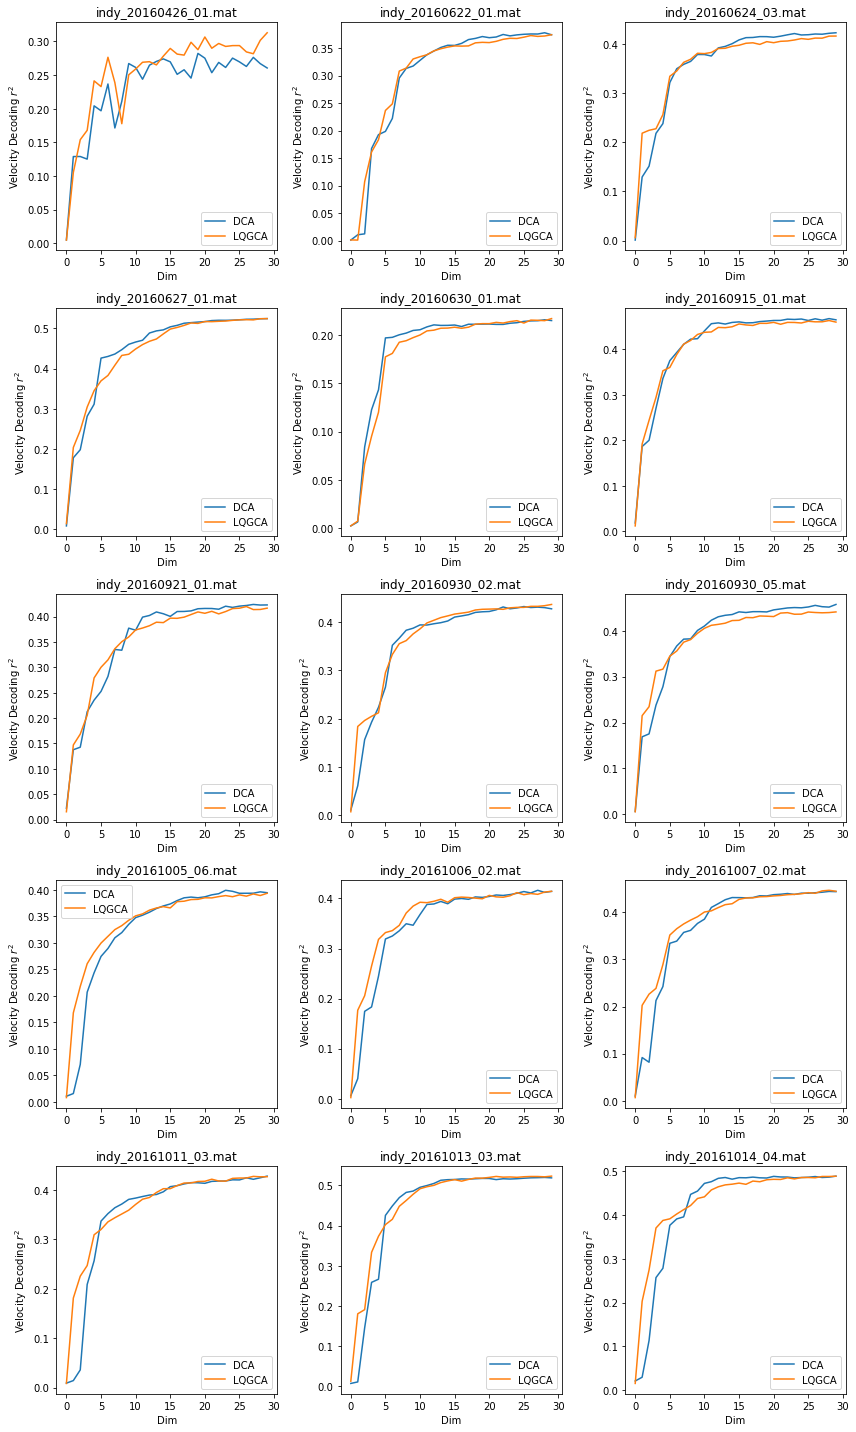

In [14]:
fig, ax = plt.subplots(5, 3, figsize=(12, 20))

for i in range(len(data_files[0:15])):
    a = ax[np.unravel_index(i, (5, 3))]
    
    # PCA
    # a.plot(np.mean(r2[i, :, 0, :, 1], axis=1))
    # DCA
    a.plot(np.mean(r2[i, :, 1, :, 1], axis=1))
    # KCA causal
#    a.plot(np.mean(r2[i, :, 2, :, 1], axis=1))
    # KCA acausal
 #   a.plot(np.mean(r2[i, :, 3, :, 1], axis=1))
    # KCA balanced
#    a.plot(np.mean(r2[i, :, 4, :, 1], axis=1))

    # LQG trace
    a.plot(np.mean(r2[i, :, 5, :, 1], axis=1))

    # LQG frobenius 
#    a.plot(np.mean(r2[i, :, 6, :, 1], axis=1))

    # LQG logdetbut?
#    a.plot(np.mean(r2[i, :, 7, :, 1], axis=1))

    # LQG additive
#    a.plot(np.mean(r2[i, :, 8, :, 1], axis=1))
    a.set_title(data_files[i])
    a.set_xlabel('Dim')
    a.set_ylabel('Velocity Decoding ' + r'$r^2$')

    a.legend(['DCA', 'LQGCA'])

fig.tight_layout()
# fig.savefig('LQGCA_DCA_comparison1.pdf', bbox_inches=0, pad_inches='tight')

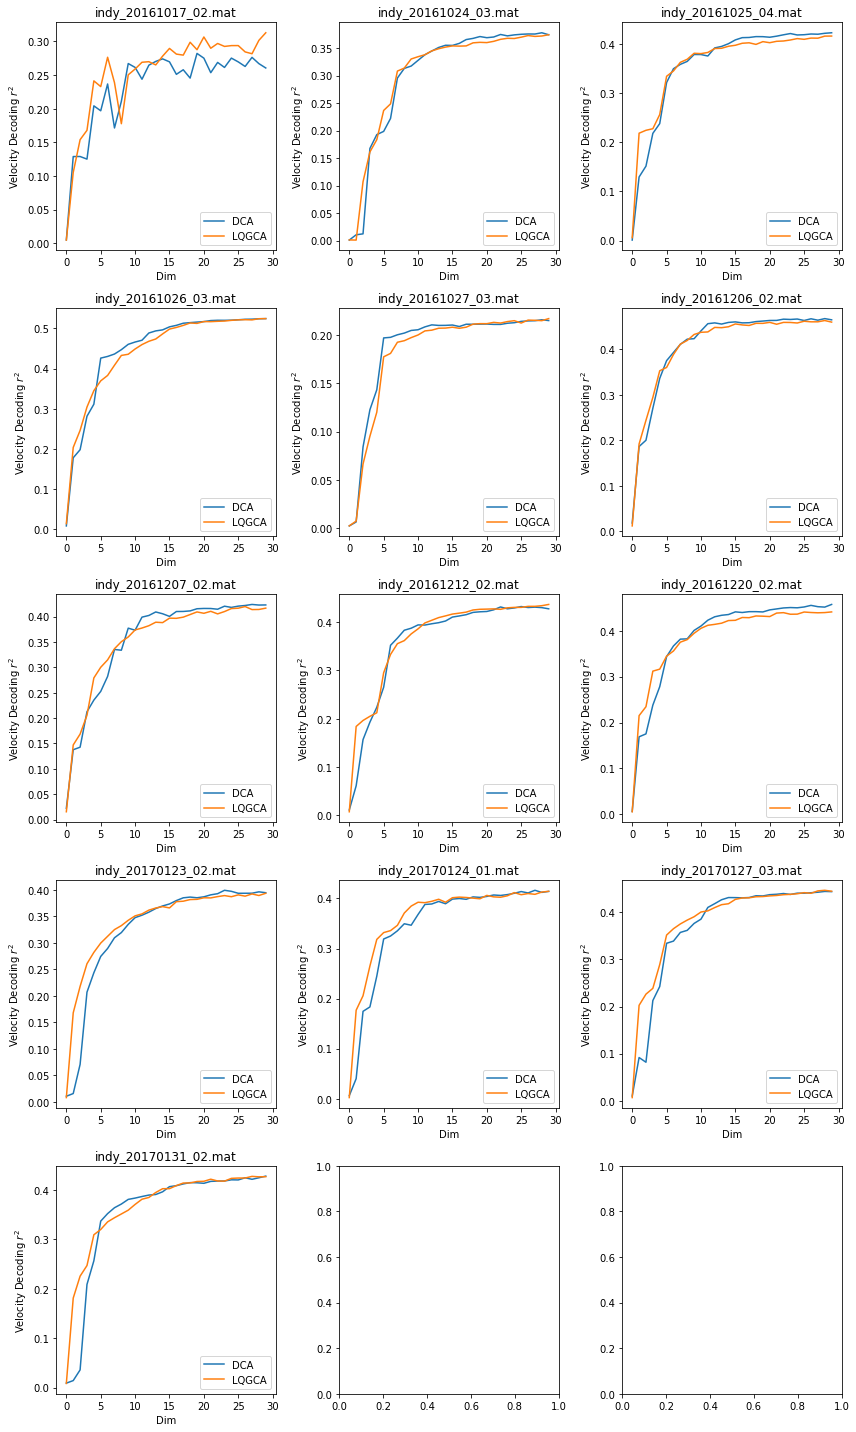

In [17]:
fig, ax = plt.subplots(5, 3, figsize=(12, 20))

for i in range(len(data_files[15:])):
    a = ax[np.unravel_index(i, (5, 3))]
    
    # PCA
    # a.plot(np.mean(r2[i, :, 0, :, 1], axis=1))
    # DCA
    a.plot(np.mean(r2[i, :, 1, :, 1], axis=1))
    # KCA causal
#    a.plot(np.mean(r2[i, :, 2, :, 1], axis=1))
    # KCA acausal
 #   a.plot(np.mean(r2[i, :, 3, :, 1], axis=1))
    # KCA balanced
#    a.plot(np.mean(r2[i, :, 4, :, 1], axis=1))

    # LQG trace
    a.plot(np.mean(r2[i, :, 5, :, 1], axis=1))

    # LQG frobenius 
#    a.plot(np.mean(r2[i, :, 6, :, 1], axis=1))

    # LQG logdetbut?
#    a.plot(np.mean(r2[i, :, 7, :, 1], axis=1))

    # LQG additive
#    a.plot(np.mean(r2[i, :, 8, :, 1], axis=1))
    a.set_title(data_files[i + 15])
    a.set_xlabel('Dim')
    a.set_ylabel('Velocity Decoding ' + r'$r^2$')

    a.legend(['DCA', 'LQGCA'])

fig.tight_layout()
fig.savefig('LQGCA_DCA_comparison2.pdf', bbox_inches=0, pad_inches='tight')

In [33]:
# Does difference to the supervised subspace consistently decrease across methods as decoding performance increases?
with open('/home/akumar/nse/neural_control/data/sabes_supervised_decoding.dat', 'rb') as f:
    sabes_supervised_df = pickle.load(f)

In [34]:
sabes_supervised_df.keys()

Index(['data_file', 'coef', 'loadings', 'trainlag', 'testlag',
       'decoding_window', 'bin_width', 'filter_fn', 'filter_kwargs', 'boxcox',
       'spike_threshold', 'fold_idx'],
      dtype='object')

In [41]:
# Subspace angles : (data_file, n_folds, method, dim)
lc = np.zeros((len(data_files), 5, 8, dims.size))

for i, data_file in enumerate(data_files):
    for j in range(5):
        sdf = apply_df_filters(sabes_supervised_df, data_file=data_file, fold_idx=j)
        for k, dim in enumerate(dims):
            for method in methods:
                method_df = apply_df_filters(sabes_df, dimreduc_method=method, data_file=data_file, dim=dim, fold_idx=j)
                if method == 'DCA':
                    lc[i, j, 0, k] = scipy.stats.spearmanr(sdf.iloc[0]['loadings'], calc_loadings(method_df.iloc[0]['coef']))[0]
                elif method == 'KCA':
                    # Causal weights (1, 0)
                    idxs = [idx for idx in range(method_df.shape[0]) if method_df.iloc[idx]['dimreduc_args']['causal_weights'] == (1, 0)]
                    assert(len(idxs) == 1)
                    lc[i, j, 1, k] = scipy.stats.spearmanr(sdf.iloc[0]['loadings'], calc_loadings(method_df.iloc[idxs[0]]['coef']))[0]

                    # Causal weights (0, 1)
                    idxs = [idx for idx in range(method_df.shape[0]) if method_df.iloc[idx]['dimreduc_args']['causal_weights'] == (0, 1)]
                    assert(len(idxs) == 1)
                    lc[i, j, 2, k] = scipy.stats.spearmanr(sdf.iloc[0]['loadings'], calc_loadings(method_df.iloc[idxs[0]]['coef']))[0]

                    # Causal weights (1, 1)
                    idxs = [idx for idx in range(method_df.shape[0]) if method_df.iloc[idx]['dimreduc_args']['causal_weights'] == (1, 1)]
                    assert(len(idxs) == 1)
                    lc[i, j, 3, k] = scipy.stats.spearmanr(sdf.iloc[0]['loadings'], calc_loadings(method_df.iloc[idxs[0]]['coef']))[0]

                elif method == 'LQGCA':
                    # Trace loss
                    idxs = [idx for idx in range(method_df.shape[0]) if method_df.iloc[idx]['dimreduc_args']['loss_type'] == 'trace']
                    assert(len(idxs) == 1)
                    lc[i, j, 4, k] = scipy.stats.spearmanr(sdf.iloc[0]['loadings'], calc_loadings(method_df.iloc[idxs[0]]['coef']))[0]

                    idxs = [idx for idx in range(method_df.shape[0]) if method_df.iloc[idx]['dimreduc_args']['loss_type'] == 'fro']
                    assert(len(idxs) == 1)
                    lc[i, j, 5, k] = scipy.stats.spearmanr(sdf.iloc[0]['loadings'], calc_loadings(method_df.iloc[idxs[0]]['coef']))[0]

                    idxs = [idx for idx in range(method_df.shape[0]) if method_df.iloc[idx]['dimreduc_args']['loss_type'] == 'logdet']
                    assert(len(idxs) == 1)
                    lc[i, j, 6, k] = scipy.stats.spearmanr(sdf.iloc[0]['loadings'], calc_loadings(method_df.iloc[idxs[0]]['coef']))[0]

                    idxs = [idx for idx in range(method_df.shape[0]) if method_df.iloc[idx]['dimreduc_args']['loss_type'] == 'additive']
                    assert(len(idxs) == 1)
                    lc[i, j, 7, k] = scipy.stats.spearmanr(sdf.iloc[0]['loadings'], calc_loadings(method_df.iloc[idxs[0]]['coef']))[0]



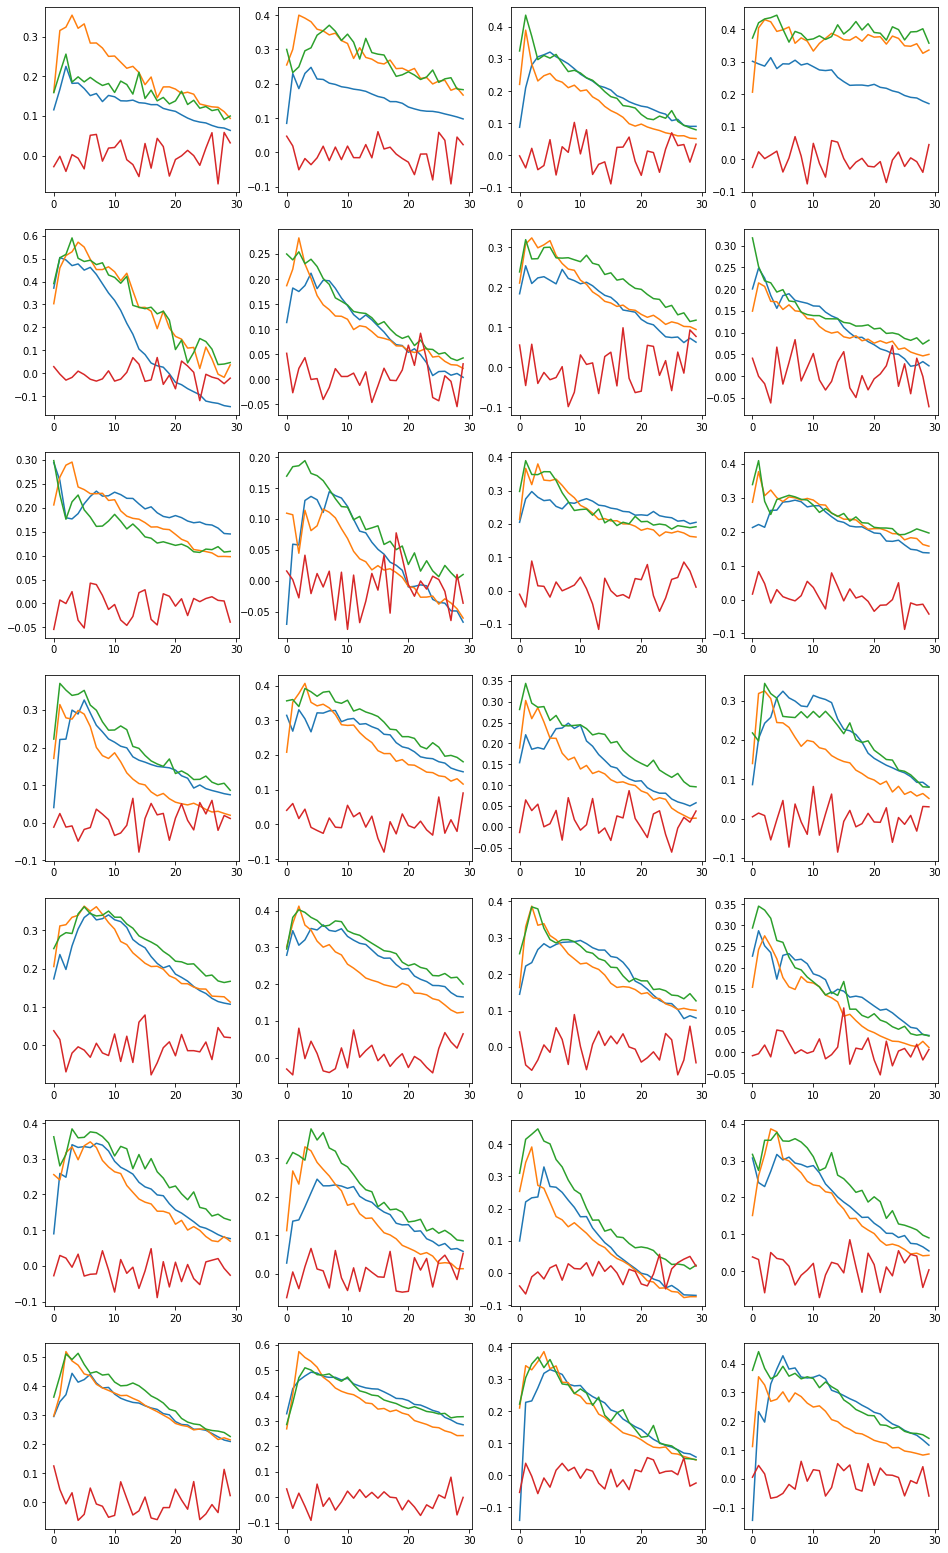

In [42]:
fig, ax = plt.subplots(7, 4, figsize=(16, 28))

for i in range(len(data_files)):
    a = ax[np.unravel_index(i, (7, 4))]
    
    # PCA
#    a.plot(np.mean(r2[i, :, 0, :, 1], axis=1))
    # DCA
    a.plot(np.mean(lc[i, :, 0, :], axis=0))
    # KCA causal
    a.plot(np.mean(lc[i, :, 1, :], axis=0))
    # KCA acausal
 #   a.plot(np.mean(r2[i, :, 3, :, 1], axis=1))
    # KCA balanced
#    a.plot(np.mean(r2[i, :, 4, :, 1], axis=1))

    # LQG trace
    a.plot(np.mean(lc[i, :, 4, :], axis=0))

    # LQG frobenius 
    a.plot(np.mean(lc[i, :, 6, :], axis=0))

    # LQG logdetbut?
#    a.plot(np.mean(r2[i, :, 7, :, 1], axis=1))

    # LQG additive
#    a.plot(np.mean(r2[i, :, 8, :, 1], axis=1))



In [ ]:
# How do we measure the subspace angles themselves? Seems to require fitting methods on the lagged state space

### Proximity to supervised subspace

Consolidate

In [6]:
import glob
import pickle

In [7]:
decoding_files = glob.glob('/mnt/Secondary/data/sabes_decoding_lag5/sabes_decoding_lag5_*.dat')

In [8]:
results_list = []
for file in decoding_files:
    with open(file, 'rb') as f:
        result = pickle.load(f)
    results_list.extend(result)


/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [13]:
sabes_lag5_df = pd.DataFrame(results_list)

In [14]:
sabes_lag5_df.keys()

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'lag', 'dimreduc_method',
       'dimreduc_args', 'coef', 'score', 'bin_width', 'filter_fn',
       'filter_kwargs', 'boxcox', 'spike_threshold', 'dim_vals', 'n_folds',
       'data_file', 'decoder', 'decoder_args', 'decoder_obj', 'r2'],
      dtype='object')

In [21]:
data_files = np.unique(sabes_lag5_df['data_file'].values)
dims = np.unique(sabes_lag5_df['dim'].values)
methods = np.unique(sabes_lag5_df['dimreduc_method'].values)

In [27]:
r2 = np.zeros((len(data_files), dims.size, 5, 5, 3))
for i, data_file in tqdm(enumerate(data_files)):
    for j, dim in enumerate(dims):
        dim_df = apply_df_filters(sabes_lag5_df, data_file=data_file, dim=dim)
        for method in methods:
            method_dim_df = apply_df_filters(dim_df, dimreduc_method=method)
            if method == 'PCA':
                assert(method_dim_df.shape[0] == 5)
                for k in range(5):
                    r2[i, j, 0, k, :] = method_dim_df.iloc[k]['r2']
            elif method == 'DCA':
                assert(method_dim_df.shape[0] == 5)
                for k in range(5):
                    r2[i, j, 1, k, :] = method_dim_df.iloc[k]['r2']
            elif method == 'KCA':
                # Causal weights (1, 0)
                idxs = [idx for idx in range(method_dim_df.shape[0]) if method_dim_df.iloc[idx]['dimreduc_args']['causal_weights'] == (1, 0)]
                assert(len(idxs) == 5)
                for k in range(5):
                    r2[i, j, 2, k, :] = method_dim_df.iloc[idxs[k]]['r2']

            elif method == 'LQGCA':
                # Trace loss
                idxs = [idx for idx in range(method_dim_df.shape[0]) if method_dim_df.iloc[idx]['dimreduc_args']['loss_type'] == 'trace']
                assert(len(idxs) == 5)
                for k in range(5):
                    r2[i, j, 3, k, :] = method_dim_df.iloc[idxs[k]]['r2']

                idxs = [idx for idx in range(method_dim_df.shape[0]) if method_dim_df.iloc[idx]['dimreduc_args']['loss_type'] == 'logdet']
                assert(len(idxs) == 5)
                for k in range(5):
                    r2[i, j, 4, k, :] = method_dim_df.iloc[idxs[k]]['r2']


    

28it [00:04,  6.69it/s]


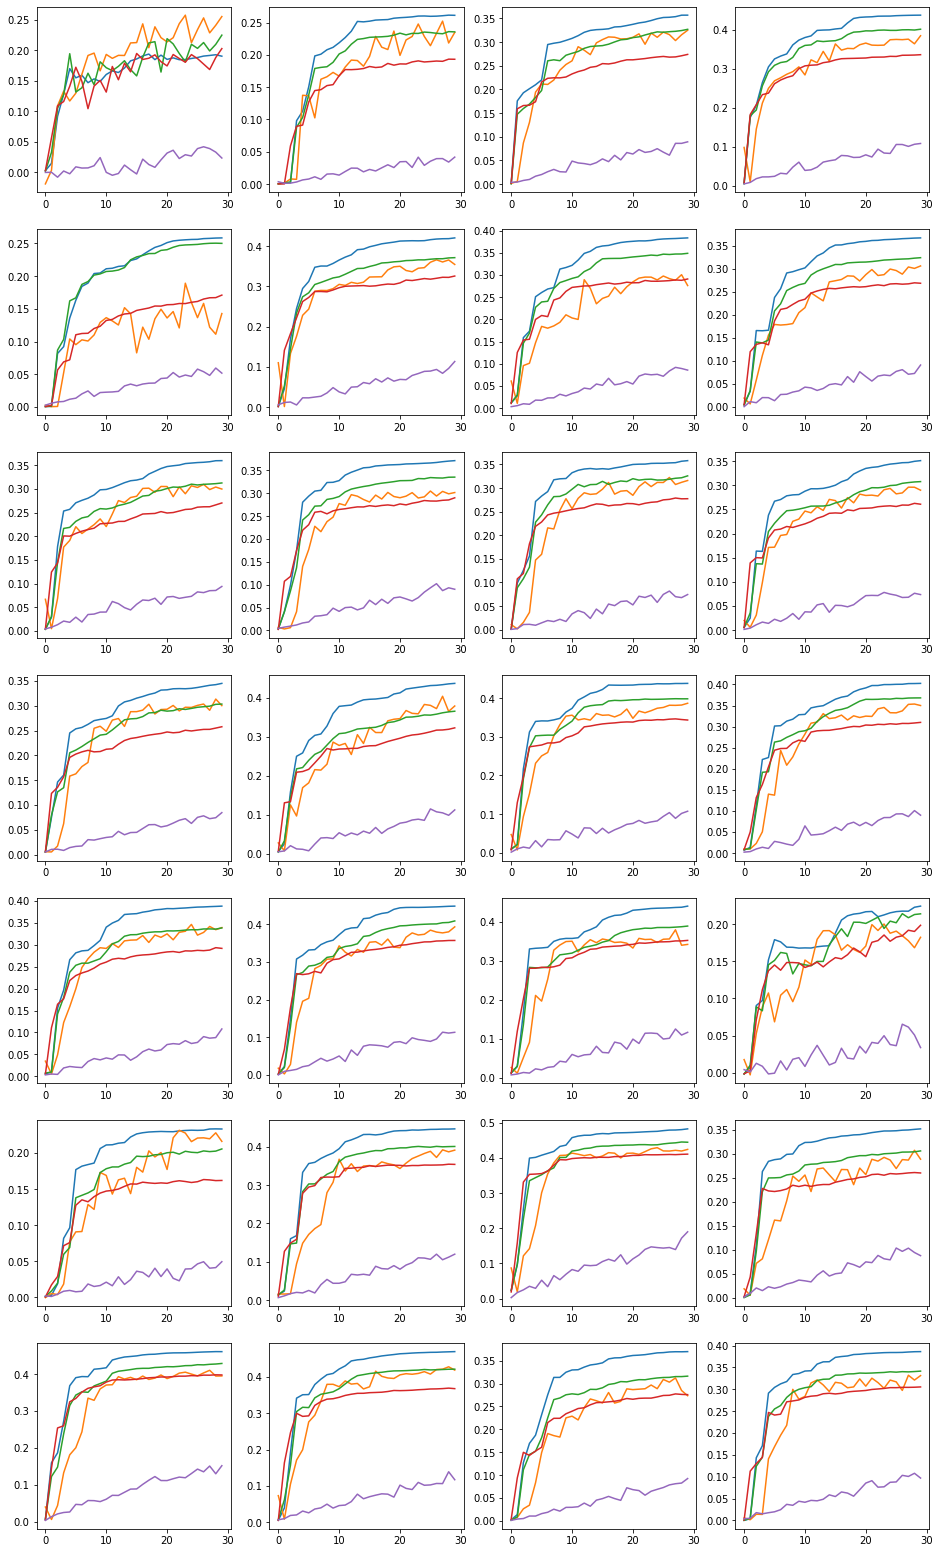

In [28]:
fig, ax = plt.subplots(7, 4, figsize=(16, 28))

for i in range(len(data_files)):
    a = ax[np.unravel_index(i, (7, 4))]
    
#    PCA
    a.plot(np.mean(r2[i, :, 0, :, 1], axis=1))
    # DCA
    a.plot(np.mean(r2[i, :, 1, :, 1], axis=1))
#    KCA causal
    a.plot(np.mean(r2[i, :, 2, :, 1], axis=1))

    # LQG trace
    a.plot(np.mean(r2[i, :, 3, :, 1], axis=1))

    # LQG logdet
    a.plot(np.mean(r2[i, :, 4, :, 1], axis=1))



### Make nice plots for group meeting

In [7]:

peanut_decoding_files = glob.glob('/mnt/Secondary/data/cosyne_results/peanut_decoding/peanut_decoding_*.dat')
peanut_kca_files = glob.glob('/mnt/Secondary/data/cosyne_results/peanut_kca/peanut_kca_*.dat')            

In [72]:
# Grab PCA results
with open('/home/akumar/nse/neural_control/data/sabes_kca_decodign_df.dat', 'rb') as f:
    sabes_decoding_df = pickle.load(f)

In [73]:
sabes_decoding_df.keys()

Index(['dim', 'fold_idx', 'dr_method', 'decoder', 'decoder_args',
       'decoder_obj', 'r2', 'data_file', 'bin_width', 'filter_fn',
       'filter_kwargs', 'boxcox', 'spike_threshold', 'trainlag', 'testlag',
       'decoding_window'],
      dtype='object')

In [74]:
sabes_decoding_df.iloc[0]['decoder_args']

{'trainlag': 4, 'testlag': 4, 'decoding_window': 5}

In [26]:
dim_vals = np.unique(sabes_df['dim'].values)
data_files = np.unique(sabes_df['data_file'].values)

In [27]:
sr2_vel_pca = np.zeros((28, 30, 5))
for i, data_file in enumerate(data_files):
    for j, dim in enumerate(dim_vals):
        pca_df = apply_df_filters(sabes_decoding_df, dim=dim, data_file=data_file, dr_method='PCA')
        for k in range(pca_df.shape[0]):
            sr2_vel_pca[i, j, k] = pca_df.iloc[k]['r2'][1]

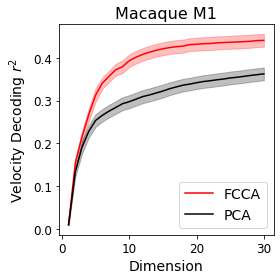

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# Average across folds and plot
# REINSERT OLS(5) IN HERE IF NEEDED

colors = ['black', 'red', '#781820', '#5563fa']


# DCA averaged over folds
dca_r2 = np.mean(r2[:, :, 1, :, 1], axis=2)
# KCA averaged over folds
kca_r2 = np.mean(r2[:, :, 2, :, 1], axis=2)
# FCCA averaged over folds
fca_r2 = np.mean(r2[:, :, 5, :, 1], axis=2)
# PCA
pca_r2 = np.mean(sr2_vel_pca, axis=-1)

# ax.fill_between(dim_vals, np.mean(dca_r2, axis=0) + np.std(dca_r2, axis=0)/np.sqrt(28),
#                 np.mean(dca_r2, axis=0) - np.std(dca_r2, axis=0)/np.sqrt(28), color=colors[0], alpha=0.25)
# ax.plot(dim_vals, np.mean(dca_r2, axis=0), color=colors[0])
# ax.fill_between(dim_vals, np.mean(kca_r2, axis=0) + np.std(kca_r2, axis=0)/np.sqrt(28),
#                 np.mean(kca_r2, axis=0) - np.std(kca_r2, axis=0)/np.sqrt(28), color=colors[1], alpha=0.25)
# ax.plot(dim_vals, np.mean(kca_r2, axis=0), color=colors[1])
ax.fill_between(dim_vals, np.mean(fca_r2, axis=0) + np.std(fca_r2, axis=0)/np.sqrt(28),
                np.mean(fca_r2, axis=0) - np.std(fca_r2, axis=0)/np.sqrt(28), color=colors[1], alpha=0.25)
ax.plot(dim_vals, np.mean(fca_r2, axis=0), color=colors[1])

ax.fill_between(dim_vals, np.mean(pca_r2, axis=0) + np.std(pca_r2, axis=0)/np.sqrt(28),
                np.mean(pca_r2, axis=0) - np.std(pca_r2, axis=0)/np.sqrt(28), color=colors[0], alpha=0.25)
ax.plot(dim_vals, np.mean(pca_r2, axis=0), color=colors[0])

ax.set_xlabel('Dimension', fontsize=14)
ax.set_ylabel('Velocity Decoding ' + r'$r^2$', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.legend(['FCCA', 'PCA'], loc='lower right', fontsize=14)
ax.set_title('Macaque M1', fontsize=16)
fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/final/indy_vel_decoding.pdf', bbox_inches='tight', pad_inches=0)

### Penanut 

In [41]:
with open('/home/akumar/nse/neural_control/data/peanut_fcca_decoding_df.dat', 'rb') as f:
    peanut_decoding_df = pickle.load(f)

In [42]:
#fig, ax = plt.subplots(4, 2, figsize=(10, 12))
epochs = np.unique(peanut_decoding_df['epoch'].values)
folds = np.unique(peanut_decoding_df['fold_idx'].values)

dimreduc_methods = ['DCA', 'PCA', 'KCAfwd', 'KCArev', 'KCAeven', 'LQGCAtrace', 'LQGCAfro', 'LQGCAlogdet', 'LQGCAadd']
KCA_dimreduc_args =  [{'T':3, 'causal_weights':(1, 0), 'n_init':5}, {'T':3, 'causal_weights':(0, 1), 'n_init':5}, {'T':3, 'causal_weights':(1, 1), 'n_init':5}]
LQGCA_dimreduc_args = [{'T':3, 'loss_type':'trace', 'n_init':5}, {'T':3, 'loss_type':'fro', 'n_init':5}, {'T':3, 'loss_type':'logdet', 'n_init':5},
                       {'T':3, 'loss_type':'additive', 'n_init':5}]

dimvals = np.unique(peanut_decoding_df['dim'].values)
decoder_args = [{'trainlag': 0, 'testlag': 0, 'decoding_window': 6}, {'trainlag': 3, 'testlag': 3, 'decoding_window': 6}, {'trainlag': 6, 'testlag': 6, 'decoding_window': 6}]

r2 = np.zeros((epochs.size, len(dimreduc_methods), len(decoder_args), folds.size, dimvals.size))

for i, epoch in enumerate(epochs):
    for j, dr_method in enumerate(dimreduc_methods):
        for k, da in enumerate(decoder_args):
            for f, fold in enumerate(folds):
                for d, dimval in enumerate(dimvals):            
                    if 'KCA' in dr_method:
                        df_ = apply_df_filters(peanut_decoding_df, epoch=epoch, dimreduc_method='KCA', fold_idx=fold, dim=dimval, decoder_args=da)
                        # Further filter by dimreduc_args
                        if dr_method == 'KCAfwd':
                            df_ = apply_df_filters(df_, dimreduc_args=KCA_dimreduc_args[0])
                        elif dr_method == 'KCArev':
                            df_ = apply_df_filters(df_, dimreduc_args=KCA_dimreduc_args[1])
                        elif dr_method == 'KCAeven':
                            df_ = apply_df_filters(df_, dimreduc_args=KCA_dimreduc_args[2])
                    elif 'LQGCA' in dr_method:
                        df_ = apply_df_filters(peanut_decoding_df, epoch=epoch, dimreduc_method='LQGCA', fold_idx=fold, dim=dimval, decoder_args=da)
                        # Further filter by dimreduc_args
                        if dr_method == 'LQGCAtrace':
                            df_ = apply_df_filters(df_, dimreduc_args=LQGCA_dimreduc_args[0])
                        elif dr_method == 'LQGCAfro':
                            df_ = apply_df_filters(df_, dimreduc_args=LQGCA_dimreduc_args[1])
                        elif dr_method == 'LQGCAlogdet':
                            df_ = apply_df_filters(df_, dimreduc_args=LQGCA_dimreduc_args[2])
                        elif dr_method == 'LQGCAadd':
                            df_ = apply_df_filters(df_, dimreduc_args=LQGCA_dimreduc_args[3])
                    else:
                        df_ = apply_df_filters(peanut_decoding_df, epoch=epoch, dimreduc_method=dr_method, fold_idx=fold, dim=dimval, decoder_args=da)

                    assert(df_.shape[0] == 1)
                    r2[i, j, k, f, d] = df_.iloc[0]['r2'][0]

In [45]:
from loaders import load_peanut
from decoders import lr_decoder

In [46]:
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

In [48]:
# Something went wrong with PCA results, just run them here real quick:
pca_r2 = np.zeros((epochs.size, len(decoder_args), 5, dimvals.size))
for i, epoch in tqdm(enumerate(epochs)):
    dat = load_peanut('/mnt/Secondary/data/peanut/data_dict_peanut_day14.obj', epoch=epoch, spike_threshold=200)
    X = dat['spike_rates']
    Y = dat['behavior']
    train_test = list(KFold(n_splits=5).split(X))
    for k, da in enumerate(decoder_args):
        for f, fold in enumerate(folds):
            for d, dimval in enumerate(dimvals):            
                df_ = apply_df_filters(peanut_decoding_df, epoch=epoch, dimreduc_method='PCA', fold_idx=fold, dim=dimval, decoder_args=da)
                coef = df_.iloc[0]['coef'][:, 0:dimval]         
                train_idxs = train_test[f][0]
                test_idxs = train_test[f][1]

                Ytrain = Y[train_idxs]
                Ytest = Y[test_idxs]

                Xtrain = X[train_idxs] @ coef
                Xtest = X[test_idxs] @ coef


                try:
                    r2_pos, r2_vel, r2_acc, decoder_obj = lr_decoder(Xtest, Xtrain, Ytest, Ytrain, **da)
                except:
                    pdb.set_trace()
                pca_r2[i, k, f, d] = r2_pos

8it [03:57, 29.72s/it]


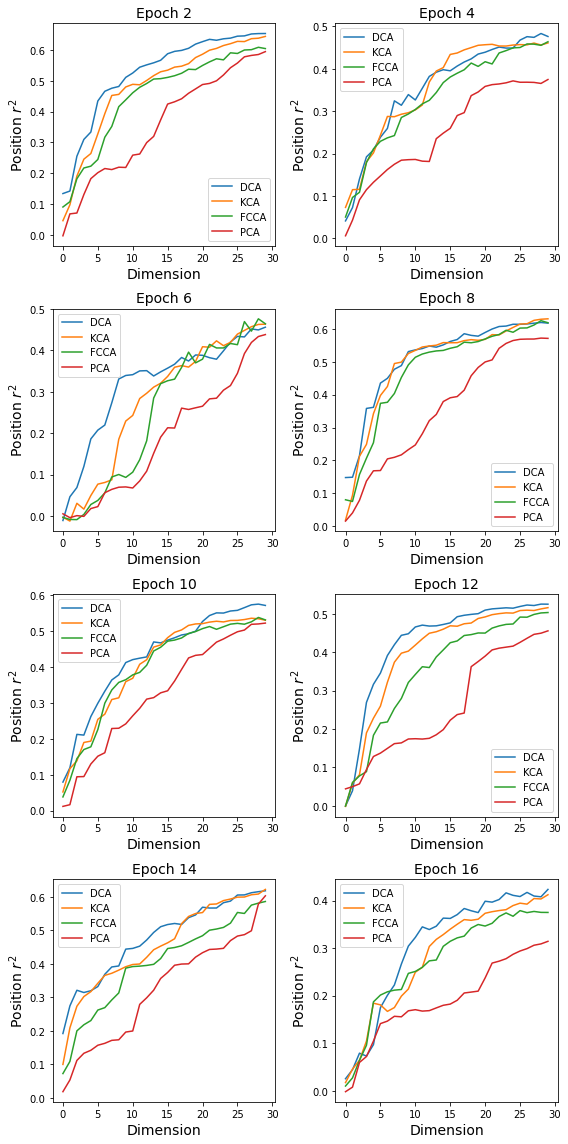

In [74]:
fig, ax = plt.subplots(4, 2, figsize=(8, 16))
for i in range(epochs.size):
    a = ax[np.unravel_index(i, (4, 2))]
    # Only include DCA, KCA, LQGCA trace 
    for k in [0, 2, 5]:
        a.plot(np.mean(r2[i, k, 0], axis=0))
    a.plot(np.mean(pca_r2[i, 0], axis=0))
    a.legend(['DCA', 'KCA', 'FCCA', 'PCA'])
    a.set_title('Epoch %d' % (2 * (i + 1)), fontsize=14)
    a.set_xlabel('Dimension', fontsize=14)
    a.set_ylabel('Position ' + r'$r^2$', fontsize=14)    
fig.tight_layout()
fig.savefig('peanut_decoding.pdf', bbox_inches='tight', pad_inches=0)

In [53]:
r2.shape

(8, 9, 3, 5, 30)

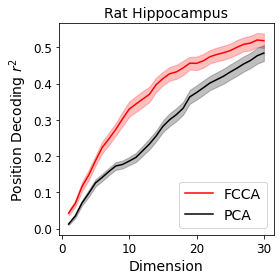

In [61]:
#fig, ax = plt.subplots(4, 2, figsize=(8, 16))
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

fca_mean = np.mean(np.mean(r2[:, 5, 0], axis=1), axis=0)

# Move the fold indices up and then reshape to calc std
fca_std = np.std(np.transpose(r2[:, 5, 0], (0, 1, 2)).reshape((-1, 30)), axis=0)/np.sqrt(40)

pca_mean = np.mean(np.mean(pca_r2[:, 0], axis=1), axis=0)

pca_std = np.std(np.transpose(pca_r2[:, 0], (0, 1, 2)).reshape((-1, 30)), axis=0)/np.sqrt(40)

ax.fill_between(np.arange(1, 31), fca_mean - fca_std, fca_mean + fca_std, color='r', alpha=0.25)
ax.fill_between(np.arange(1, 31), pca_mean - pca_std, pca_mean + pca_std, color='k', alpha=0.25)

ax.plot(np.arange(1, 31), fca_mean, color='r')
ax.plot(np.arange(1, 31), pca_mean, color='k')

ax.legend(['FCCA', 'PCA'], loc='lower right', fontsize=14)
ax.set_title('Rat Hippocampus', fontsize=14)
ax.set_xlabel('Dimension', fontsize=14)
ax.set_ylabel('Position Decoding ' + r'$r^2$', fontsize=14)    
ax.tick_params(axis='both', labelsize=12)

fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/final/peanut_decoding.pdf', bbox_inches='tight', pad_inches=0)
# fig.savefig('peanut_decoding.pdf', bbox_inches='tight', pad_inches=0)

### Indy parametric dimreduc


In [5]:
from tqdm import tqdm

In [6]:
files = glob.glob('/home/akumar/nse/neural_control/data/indy_parametric_decoding/*.dat')

r2 = []
loader_args = []

for file in tqdm(files):
    with open(file, 'rb') as f:
        df = pickle.load(f)

    loader_args.append(df.iloc[0]['loader_args'])

100%|██████████| 16/16 [00:19<00:00,  1.23s/it]


In [17]:
# Need to record r^2 across the different files
files = glob.glob('/home/akumar/nse/neural_control/data/indy_parametric_decoding/*.dat')

r2 = []
loader_args = []

for file in tqdm(files):
    with open(file, 'rb') as f:
        df = pickle.load(f)

    loader_args.append(df.iloc[0]['loader_args'])
    data_files = np.unique(df['data_file'].values)
    folds = np.unique(df['fold_idx'].values)
    #dimreduc_methods = np.unique(df['dimreduc_method'].values)
    dimreduc_methods = ['DCA', 'KCAfwd', 'KCArev', 'LQGCA', 'PCA']
    KCA_dimreduc_args =  [{'T':3, 'causal_weights':(1, 0), 'n_init':5}, {'T':3, 'causal_weights':(0, 1), 'n_init':5}]
    dimvals = np.unique(df['dim'].values)
    
    # Copied from the submit file
    decoder_args = [{'trainlag': 4, 'testlag': 4, 'decoding_window':1}, 
                    {'trainlag': 4, 'testlag': 4, 'decoding_window':3}, 
                    {'trainlag': 0, 'testlag': 0,  'decoding_window':3},
                    {'trainlag': 0, 'testlag': 0,  'decoding_window':1}]

    # Pos, vel, acc
    r2array = np.zeros((data_files.size, len(dimreduc_methods), len(decoder_args), folds.size, dimvals.size, 3))

    for k, da in enumerate(decoder_args):
        df1 = apply_df_filters(df, decoder_args=da)
        for i, data_file in tqdm(enumerate(data_files)):
            for j, dr_method in enumerate(dimreduc_methods):
                for f, fold in enumerate(folds):
                    for d, dimval in enumerate(dimvals):            
                        if 'KCA' in dr_method:
                            df_ = apply_df_filters(df1, data_file=data_file, dimreduc_method='KCA', fold_idx=fold, dim=dimval)
                            # Further filter by dimreduc_args
                            if dr_method == 'KCAfwd':
                                df_ = apply_df_filters(df_, dimreduc_args=KCA_dimreduc_args[0])
                            elif dr_method == 'KCArev':
                                df_ = apply_df_filters(df_, dimreduc_args=KCA_dimreduc_args[1])
                        else:
                            df_ = apply_df_filters(df1, data_file=data_file, dimreduc_method=dr_method, fold_idx=fold, dim=dimval)

                        assert(df_.shape[0] == 1)
                        r2array[i, j, k, f, d] = df_.iloc[0]['r2']


    r2.append(r2array)

6it [00:02,  2.61it/s]
6it [00:02,  2.76it/s]
6it [00:02,  2.75it/s]
6it [00:02,  2.76it/s]
6it [00:02,  2.69it/s]
6it [00:02,  2.69it/s]
6it [00:02,  2.68it/s]
6it [00:02,  2.69it/s]
6it [00:02,  2.67it/s]
6it [00:02,  2.66it/s]
6it [00:02,  2.72it/s]
6it [00:02,  2.71it/s]
6it [00:02,  2.67it/s]
6it [00:02,  2.69it/s]
6it [00:02,  2.68it/s]
6it [00:02,  2.68it/s]
6it [00:02,  2.67it/s]
6it [00:02,  2.67it/s]
6it [00:02,  2.70it/s]
6it [00:02,  2.70it/s]
6it [00:02,  2.66it/s]
6it [00:02,  2.66it/s]
6it [00:02,  2.66it/s]
6it [00:02,  2.55it/s]
6it [00:02,  2.57it/s]
6it [00:02,  2.74it/s]
6it [00:02,  2.68it/s]
6it [00:02,  2.69it/s]
6it [00:02,  2.74it/s]
6it [00:02,  2.75it/s]
6it [00:02,  2.69it/s]
6it [00:02,  2.69it/s]
6it [00:02,  2.62it/s]
6it [00:02,  2.73it/s]
6it [00:02,  2.69it/s]
6it [00:02,  2.68it/s]
6it [00:02,  2.70it/s]
6it [00:02,  2.71it/s]
6it [00:02,  2.69it/s]
6it [00:02,  2.70it/s]
6it [00:02,  2.69it/s]
6it [00:02,  2.67it/s]
6it [00:02,  2.69it/s]
6it [00:02,

In [18]:
r2 = np.array(r2)

In [20]:
with open('indy_parametric_r2.dat', 'wb') as f:
    f.write(pickle.dumps(r2))
# with open('indy_parametric_r2.dat', 'rb') as f:
#     r2 = pickle.load(f)

In [54]:
# Need to do the following analyses:
# We should narrow down to loader_arg/decoding_window combinations that give rise to the best decoding performance, irrespective of window size

# We should see how close subspaces are for the different loader/decoding args - 

# Window sizes are probably too large to be sensible.

In [ ]:
for i, la in enumerate(loader_args):
    
    fig, ax = plt.subplots(6, 4, figsize=(16, 24))
    for j in range(len(data_files)):
        for k in range(len(decoders_args)):
            a = ax[j, k]
            for h in range(len(dimreduc_methods)):
                a.plot(np.mean(r2[i, j, h, k, ..., 0], axis=0))
            a.legend(dimreduc_methods)
    fig.suptitle(la)
    fig.tight_layout()
    fig.savefig('/home/akumar/nse/neural_control/figs/indy_parametric_decoding/%d_pos.pdf' % i, bbox_inches='tight', pad_inches=0)

    fig, ax = plt.subplots(6, 4, figsize=(16, 24))
    for j in range(len(data_files)):
        for k in range(len(decoders_args)):
            a = ax[j, k]
            for h in range(len(dimreduc_methods)):
                a.plot(np.mean(r2[i, j, h, k, ..., 1], axis=0))
            a.legend(dimreduc_methods)
    fig.suptitle(la)
    fig.tight_layout()
    fig.savefig('/home/akumar/nse/neural_control/figs/indy_parametric_decoding/%d_vel.pdf' % i, bbox_inches='tight', pad_inches=0)




In [9]:
dimreduc_methods = ['DCA', 'KCAfwd', 'KCArev', 'LQGCA', 'PCA']

In [32]:
loader_args[4]['filter_fn'] != 'none'

False

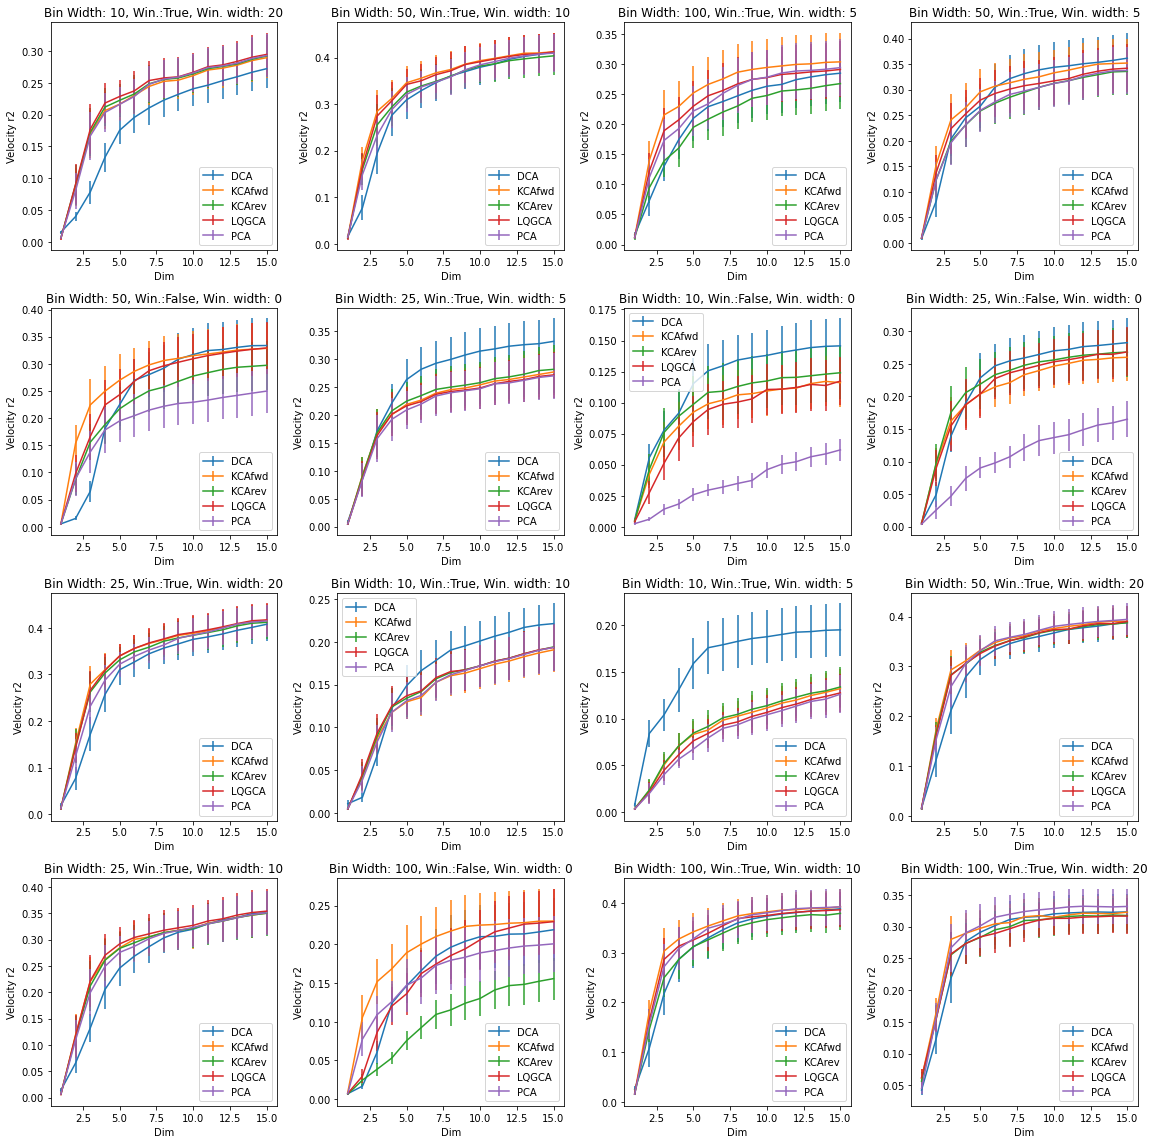

In [39]:
# For simplicity, let's stick to the       {'trainlag': 4, 'testlag': 4, 'decoding_window':3}
# Plot the mean across data files, across all loader args
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for i in range(len(loader_args)):
    a = ax[np.unravel_index(i, (4, 4))]

    for h in range(len(dimreduc_methods)):
        r2_avg = np.mean(r2[i, :, h, 1, ..., 1], axis=1)
        a.errorbar(np.arange(1, r2_avg.shape[-1] + 1), np.mean(r2_avg, axis=0), yerr=np.std(r2_avg, axis=0)/np.sqrt(5))
        a.legend(dimreduc_methods)

    has_window = loader_args[i]['filter_fn'] != 'none'
    if has_window:
        window_width = loader_args[i]['filter_kwargs']['window_length']
    else:
        window_width = 0

    a.set_title('Bin Width: %d, Win.:%s, Win. width: %d' % (loader_args[i]['bin_width'], has_window, window_width))
    a.set_ylabel('Velocity r2')
    a.set_xlabel('Dim')
fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/indy_parametric_decoding/summary.pdf')

In [7]:
# Calculate loadings correlations at d = 5
with open('/home/akumar/nse/neural_control/data/indy_parametric_dimreduc_df.dat', 'rb') as f:
    dimreduc_df = pickle.load(f)

In [16]:
dimreduc_df.iloc[100]['dimreduc_args']

{'T': 3, 'causal_weights': (1, 0), 'n_init': 5}

In [21]:
# calculate pairwise loadings correlations 
data_files = np.unique(dimreduc_df['data_file'].values)
dimreduc_methods = ['DCA', 'KCAfwd', 'KCArev', 'LQGCA', 'PCA']
folds = np.arange(5)
KCA_dimreduc_args =  [{'T':3, 'causal_weights':(1, 0), 'n_init':5}, {'T':3, 'causal_weights':(0, 1), 'n_init':5}]

loadings_r = np.zeros((len(loader_args), data_files.size, 5, 5, 5))

for i, loader_arg in enumerate(loader_args):
    df = apply_df_filters(dimreduc_df, loader_args=loader_arg)
    for j, data_file in enumerate(data_files):
        loadings = []
        for f, fold in enumerate(folds):
            loadings_fold = []
            for k1, dr_method in enumerate(dimreduc_methods):
                if 'KCA' in dr_method:
                    df_ = apply_df_filters(df, data_file=data_file, dimreduc_method='KCA', fold_idx=fold, dim=5)
                    # Further filter by dimreduc_args
                    if dr_method == 'KCAfwd':
                        df_ = apply_df_filters(df_, dimreduc_args=KCA_dimreduc_args[0])
                    elif dr_method == 'KCArev':
                        df_ = apply_df_filters(df_, dimreduc_args=KCA_dimreduc_args[1])
                else:
                    df_ = apply_df_filters(df, data_file=data_file, dimreduc_method=dr_method, fold_idx=fold, dim=5)

                loadings_fold.append(calc_loadings(df_.iloc[0]['coef']))

            loadings.append(loadings_fold)
        loadings = np.array(loadings)
        for fold in range(5):
            for k1 in range(5):
                for k2 in range(5):
                    loadings_r[i, j, fold, k1, k2] = scipy.stats.spearmanr(loadings[fold, k1], loadings[fold, k2])[0]


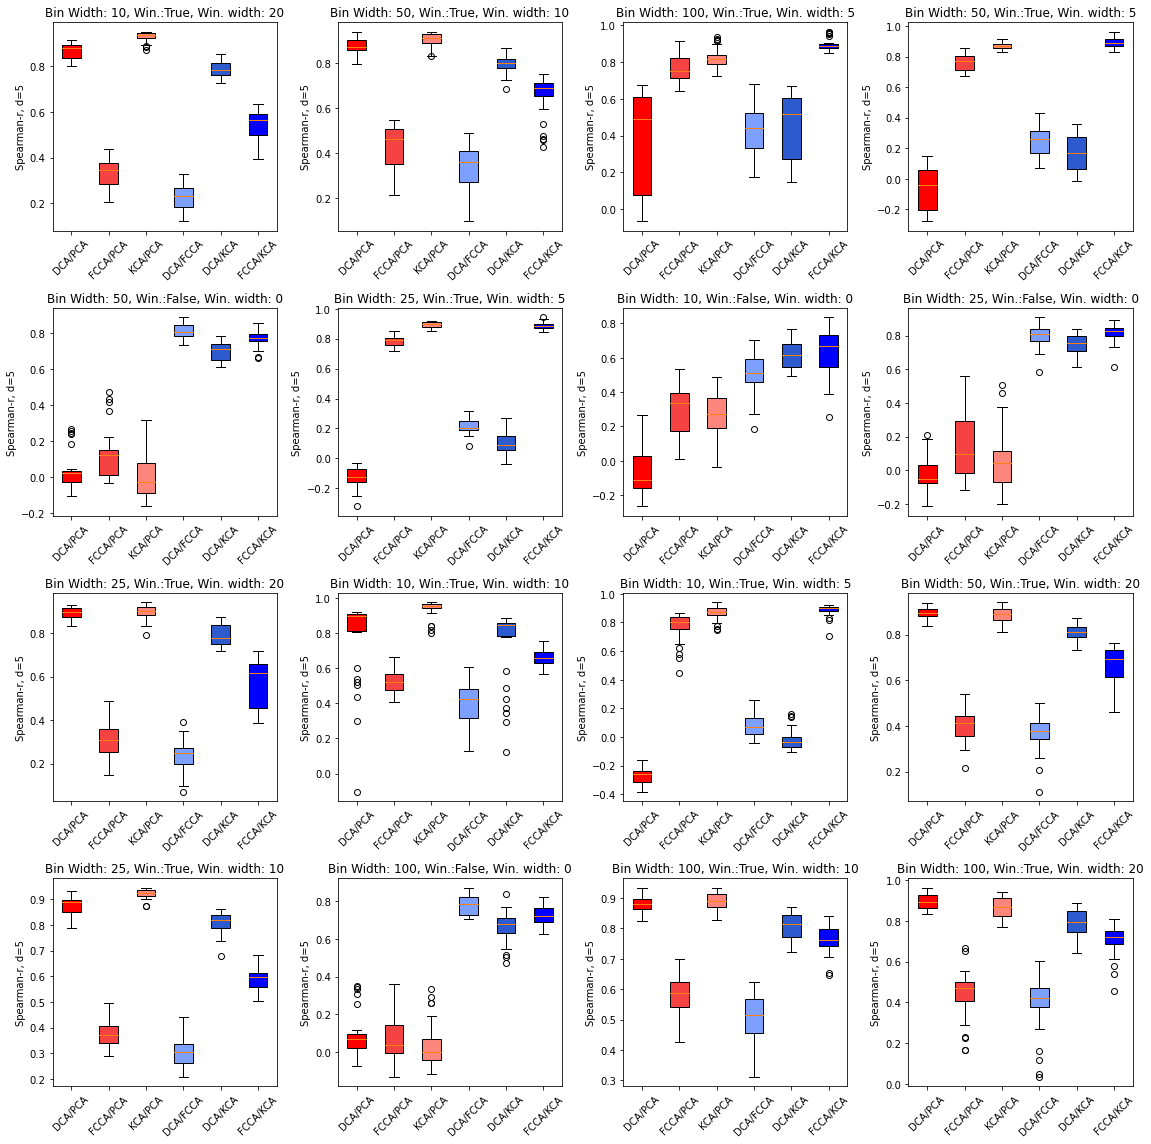

In [28]:
# boxplots of the loadings_r for each loader arg and the 25 - 5 combinations across data_files and folds
fig, ax = plt.subplots(4, 4, figsize=(16, 16))

for i in range(len(loader_args)):
    a = ax[np.unravel_index(i, (4, 4))]

    # To make this comprehensible, we limit ourselves to the following comparisons:
    # (DCA, PCA)
    # (FCCA, PCA)
    # (KCAfwd, PCA)
    # (DCA, FCCA)
    # (DCA, KCAfwd)
    # (FCCA, KCAfwd)
    bplot = a.boxplot([loadings_r[i, :, :, 0, 4].ravel(),
                       loadings_r[i, :, :, 3, 4].ravel(),
                       loadings_r[i, :, :, 1, 4].ravel(),
                       loadings_r[i, :, :, 0, 3].ravel(),
                       loadings_r[i, :, :, 0, 1].ravel(),
                       loadings_r[i, :, :, 3, 1].ravel()], patch_artist=True)

    # fill with colors
    colors = ['red', '#f54242', '#fc867c', '#7ca0fc', '#2d5acc', 'blue']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    a.set_xticklabels(['DCA/PCA', 'FCCA/PCA', 'KCA/PCA', 'DCA/FCCA', 'DCA/KCA', 'FCCA/KCA'], rotation=45)
    has_window = loader_args[i]['filter_fn'] != 'none'
    if has_window:
        window_width = loader_args[i]['filter_kwargs']['window_length']
    else:
        window_width = 0

    a.set_title('Bin Width: %d, Win.:%s, Win. width: %d' % (loader_args[i]['bin_width'], has_window, window_width))
    a.set_ylabel('Spearman-r, d=5')

fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/indy_parametric_decoding/loadings_correlation.pdf', bbox_inches='tight', pad_inches=0)    


### Indy trialized

In [6]:
with open('/home/akumar/nse/neural_control/data/indytrialized_decoding_df.dat', 'rb') as f:
    trialized_df = pickle.load(f)

In [7]:
trialized_df.shape

(223200, 18)

In [8]:
trialized_df.keys()

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'dimreduc_method',
       'dimreduc_args', 'coef', 'score', 'decoder', 'decoder_args',
       'decoder_obj', 'r2', 'data_file', 'loader', 'loader_args', 'task_args',
       'data_path', 'results_file'],
      dtype='object')

In [26]:
np.unique(trialized_df['dimreduc_method'].values)

array(['DCA', 'KCA', 'LQGCA'], dtype=object)

In [27]:
# PCA is strangely missing... fill in the gap
with open('/home/akumar/nse/neural_control/data/indy_trialized_dimreduc_df.dat', 'rb') as f:
    trialized_dimreduc_df = pickle.load(f)

In [16]:
loader_args = [{'bin_width':100, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'M1', 'segment':True},
               {'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'M1', 'segment':True},
               {'bin_width':25, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'M1', 'segment':True},
               {'bin_width':10, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'M1', 'segment':True}]

for bin_width in [10, 25, 50, 100]:
    for window_length in [5, 10, 20]:
        loader_args.append({'bin_width':bin_width, 'filter_fn':'window', 'filter_kwargs':{'window_name':'hann', 'window_length':window_length}, 
                            'boxcox':0.5, 'spike_threshold':100, 'region':'M1', 'segment':True})

data_files = np.unique(trialized_df['data_file'].values)
folds = np.unique(trialized_df['fold_idx'].values)
#dimreduc_methods = np.unique(df['dimreduc_method'].values)
dimreduc_methods = ['DCA', 'KCAfwd', 'KCArev', 'LQGCA', 'PCA']
KCA_dimreduc_args =  [{'T':3, 'causal_weights':(1, 0), 'n_init':5}, {'T':3, 'causal_weights':(0, 1), 'n_init':5}]
dimvals = np.unique(trialized_df['dim'].values)

# Copied from the submit file
decoder_args = [{'trainlag': 4, 'testlag': 4, 'decoding_window':1}, 
                {'trainlag': 4, 'testlag': 4, 'decoding_window':3}, 
                {'trainlag': 0, 'testlag': 0,  'decoding_window':3},
                {'trainlag': 0, 'testlag': 0,  'decoding_window':1}]

# Pos, vel, acc
r2array = np.zeros((len(loader_args), data_files.size, len(dimreduc_methods), len(decoder_args), folds.size, dimvals.size, 3))

for h, la in tqdm(enumerate(loader_args)):
    for k, da in tqdm(enumerate(decoder_args)):
        # Apply the dictioanry based lookups first
        df = apply_df_filters(trialized_df, decoder_args=da, loader_args=la)
        for i, data_file in enumerate(data_files):
            for j, dr_method in enumerate(dimreduc_methods):
                for f, fold in enumerate(folds):
                    for d, dimval in enumerate(dimvals):            
                        if 'KCA' in dr_method:
                            df_ = apply_df_filters(df, data_file=data_file, dimreduc_method='KCA', fold_idx=fold, dim=dimval)
                            # Further filter by dimreduc_args
                            if dr_method == 'KCAfwd':
                                df_ = apply_df_filters(df_, dimreduc_args=KCA_dimreduc_args[0])
                            elif dr_method == 'KCArev':
                                df_ = apply_df_filters(df_, dimreduc_args=KCA_dimreduc_args[1])
                        else:
                            df_ = apply_df_filters(df, data_file=data_file, dimreduc_method=dr_method, fold_idx=fold, dim=dimval)

                        # Might be some incomplete decoding
                        if df_.shape[0] == 0:
                            r2array[h, i, j, k, f, d] = [np.nan, np.nan, np.nan]
                        else:
                            r2array[h, i, j, k, f, d] = df_.iloc[0]['r2']

4it [00:19,  4.93s/it]
4it [00:20,  5.19s/it]
4it [00:20,  5.22s/it]
4it [00:20,  5.18s/it]
4it [00:20,  5.15s/it]
4it [00:20,  5.21s/it]
4it [00:20,  5.13s/it]
4it [00:20,  5.20s/it]
4it [00:20,  5.18s/it]
4it [00:20,  5.17s/it]
4it [00:20,  5.17s/it]
4it [00:20,  5.16s/it]
4it [00:20,  5.22s/it]
4it [00:19,  4.94s/it]
4it [00:19,  4.90s/it]
4it [00:19,  4.99s/it]
16it [05:27, 20.49s/it]


In [17]:
with open('indy_trialized_r2.dat', 'wb') as f:
    f.write(pickle.dumps(r2array))

In [21]:
r2array.shape

(16, 6, 5, 4, 5, 30, 3)

In [25]:
r2array[:, :, 4, ...]

array([[[[[[nan, nan, nan],
           [nan, nan, nan],
           [nan, nan, nan],
           ...,
           [nan, nan, nan],
           [nan, nan, nan],
           [nan, nan, nan]],

          [[nan, nan, nan],
           [nan, nan, nan],
           [nan, nan, nan],
           ...,
           [nan, nan, nan],
           [nan, nan, nan],
           [nan, nan, nan]],

          [[nan, nan, nan],
           [nan, nan, nan],
           [nan, nan, nan],
           ...,
           [nan, nan, nan],
           [nan, nan, nan],
           [nan, nan, nan]],

          [[nan, nan, nan],
           [nan, nan, nan],
           [nan, nan, nan],
           ...,
           [nan, nan, nan],
           [nan, nan, nan],
           [nan, nan, nan]],

          [[nan, nan, nan],
           [nan, nan, nan],
           [nan, nan, nan],
           ...,
           [nan, nan, nan],
           [nan, nan, nan],
           [nan, nan, nan]]],


         [[[nan, nan, nan],
           [nan, nan, nan],
           [

In [ ]:
for i, la in enumerate(loader_args):
    
    fig, ax = plt.subplots(6, 4, figsize=(16, 24))
    for j in range(len(data_files)):
        for k in range(len(decoder_args)):
            a = ax[j, k]
            for h in range(len(dimreduc_methods)):
                a.plot(np.mean(r2array[i, j, h, k, ..., 0], axis=0))
            a.legend(dimreduc_methods)
    fig.suptitle(la)
    fig.tight_layout()
    fig.savefig('/home/akumar/nse/neural_control/figs/indy_trialized_decoding/%d_pos.pdf' % i, bbox_inches='tight', pad_inches=0)

    fig, ax = plt.subplots(6, 4, figsize=(16, 24))
    for j in range(len(data_files)):
        for k in range(len(decoder_args)):
            a = ax[j, k]
            for h in range(len(dimreduc_methods)):
                a.plot(np.mean(r2array[i, j, h, k, ..., 1], axis=0))
            a.legend(dimreduc_methods)
    fig.suptitle(la)
    fig.tight_layout()
    fig.savefig('/home/akumar/nse/neural_control/figs/indy_trialized_decoding/%d_vel.pdf' % i, bbox_inches='tight', pad_inches=0)


### CV Decoding

In [6]:
with open('/home/akumar/nse/neural_control/data/cv_dimreduc_df.dat', 'rb') as f:
    cv_df = pickle.load(f)

In [7]:
task_args = [{'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'DCA', 'dimreduc_args': {'T':3, 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'KCA', 'dimreduc_args': {'T':3, 'causal_weights':(1, 0), 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'KCA', 'dimreduc_args': {'T':3, 'causal_weights':(0, 1), 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'KCA', 'dimreduc_args': {'T':3, 'causal_weights':(1, 1), 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'LQGCA', 'dimreduc_args': {'T':3, 'loss_type':'trace', 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'LQGCA', 'dimreduc_args': {'T':3, 'loss_type':'fro', 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'LQGCA', 'dimreduc_args': {'T':3, 'loss_type':'logdet', 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'LQGCA', 'dimreduc_args': {'T':3, 'loss_type':'additive', 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'PCA', 'dimreduc_args': {}}]

In [8]:
KCA_args = [{'T':3, 'causal_weights':(1, 0), 'n_init':5}, {'T':3, 'causal_weights':(0, 1), 'n_init':5}]
LQGCA_args = [{'T':3, 'loss_type':'trace', 'n_init':5}, {'T':3, 'loss_type':'fro', 'n_init':5}]

In [9]:
cv_df.keys()

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'dimreduc_method',
       'dimreduc_args', 'coef', 'score'],
      dtype='object')

In [10]:
np.unique(cv_df['dimreduc_method'].values)

array(['DCA', 'KCA', 'LQGCA', 'PCA'], dtype=object)

In [11]:
folds = np.arange(5)
dimvals = np.unique(cv_df['dim'].values)

In [12]:
dimreduc_methods = ['DCA', 'KCAfwd', 'KCArev', 'LQGCAtrace', 'LQGCAfro', 'PCA']

In [13]:
from loaders import load_cv
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

In [84]:
dat = load_cv('/mnt/Secondary/data/EC2_hg.h5')

In [86]:
np.max(dat['spike_rates'])

82.667114

In [15]:
cv_df.iloc[0]['train_idxs'].shape

(2052,)

In [ ]:
# See analysis_scripts/cv_decoding

In [6]:
decoding_files = glob.glob('/home/akumar/nse/neural_control/analysis_scripts/decoding_list2_*.dat')

In [7]:
rl = []
for i, data_file in enumerate(decoding_files):
    with open(data_file, 'rb') as f:
        rl.extend(pickle.load(f))

In [14]:
decoding_files = glob.glob('/home/akumar/nse/neural_control/analysis_scripts/decoding_list_*.dat')
rl = []
for i, data_file in enumerate(decoding_files):
    with open(data_file, 'rb') as f:
        rl.extend(pickle.load(f))

In [15]:
cv_decoding_df2 = pd.DataFrame(rl)

In [9]:
cv_decoding_df = pd.DataFrame(rl)

In [10]:
cv_decoding_df.keys()

Index(['dr_method', 'fold', 'dimval', 'acc', 'classifier_coef'], dtype='object')

In [11]:
acc = np.zeros((6, 5, 30))
for i, dr_method in enumerate(np.unique(cv_decoding_df['dr_method'].values)):
    for j, fold in enumerate(np.arange(5)):
        for k, dim in enumerate(np.unique(cv_decoding_df['dimval'].values)):
            df_ = apply_df_filters(cv_decoding_df, dr_method=dr_method, fold=fold, dimval=dim)
            assert(df_.shape[0] == 1)
            acc[i, j, k] = df_.iloc[0]['acc']

In [16]:
acc2 = np.zeros((6, 5, 30))
for i, dr_method in enumerate(np.unique(cv_decoding_df2['dr_method'].values)):
    for j, fold in enumerate(np.arange(5)):
        for k, dim in enumerate(np.unique(cv_decoding_df2['dimval'].values)):
            df_ = apply_df_filters(cv_decoding_df2, dr_method=dr_method, fold=fold, dimval=dim)
            assert(df_.shape[0] == 1)
            acc2[i, j, k] = df_.iloc[0]['acc']

In [12]:
np.unique(cv_decoding_df['dr_method'].values)

array(['DCA10', 'DCA20', 'KCA10', 'KCA20', 'LQGCA10', 'LQGCA20'],
      dtype=object)

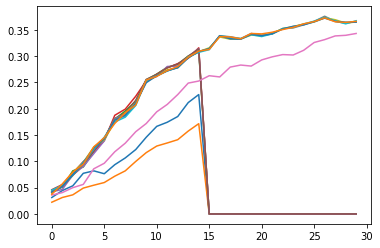

In [17]:
plt.plot(np.mean(acc, axis=1).T)
plt.plot(np.mean(acc2, axis=1).T)

In [18]:
# Need to run the cv dim scan notebook overnight

### Indy sign fix

In [5]:
with open('/home/akumar/nse/neural_control/data/sabes_decoding_sf.dat', 'rb') as f:
    rl = pickle.load(f)

In [6]:
sabes_df = pd.DataFrame(rl)

In [7]:
sabes_df.keys()

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'dimreduc_method',
       'dimreduc_args', 'coef', 'score', 'decoder', 'decoder_args',
       'decoder_obj', 'r2', 'task_args', 'data_file', 'data_path', 'loader',
       'loader_args', 'results_file'],
      dtype='object')

In [8]:
sabes_df.iloc[0]['decoder_args']

{'decoding_window': 5, 'testlag': 4, 'trainlag': 4}

In [9]:
data_files = np.unique(sabes_df['data_file'].values)
dims = np.unique(sabes_df['dim'].values)
r2fc = np.zeros((len(data_files), dims.size, 2, 4, 5, 3))
scores2 = np.zeros((len(data_files), dims.size, 2, 5))
dr_args = [{'T': 3, 'loss_type': 'trace', 'n_init': 10}, {'T': 5, 'loss_type': 'trace', 'n_init': 10}]
# dec_args = [{'trainlag': 4, 'testlag': 4, 'decoding_window':1}, 
# 		   {'trainlag': 4, 'testlag': 4, 'decoding_window':3}, 
# 	       {'trainlag': 0, 'testlag': 0,  'decoding_window':3},
# 		   {'trainlag': 0, 'testlag': 0,  'decoding_window':1}]
dec_args = [{'trainlag':4, 'testlag':4, 'decoding_window':5}]


for k1,  dra in enumerate(dr_args):
    for k2, dec in enumerate(dec_args):
        df = apply_df_filters(sabes_df, dimreduc_args=dra, decoder_args=dec)    
        for i, data_file in tqdm(enumerate(data_files)):
            for j, dim in enumerate(dims):               
                for f in range(5):
                    dim_fold_df = apply_df_filters(df, data_file=data_file, dim=dim, fold_idx=f)
                    # Trace loss
                    assert(dim_fold_df.shape[0] == 1)
                    r2fc[i, j, k1, k2, f, :] = dim_fold_df.iloc[0]['r2']
                    scores2[i, j, k1, f] = dim_fold_df.iloc[0]['score']

28it [00:04,  6.98it/s]
28it [00:04,  6.98it/s]


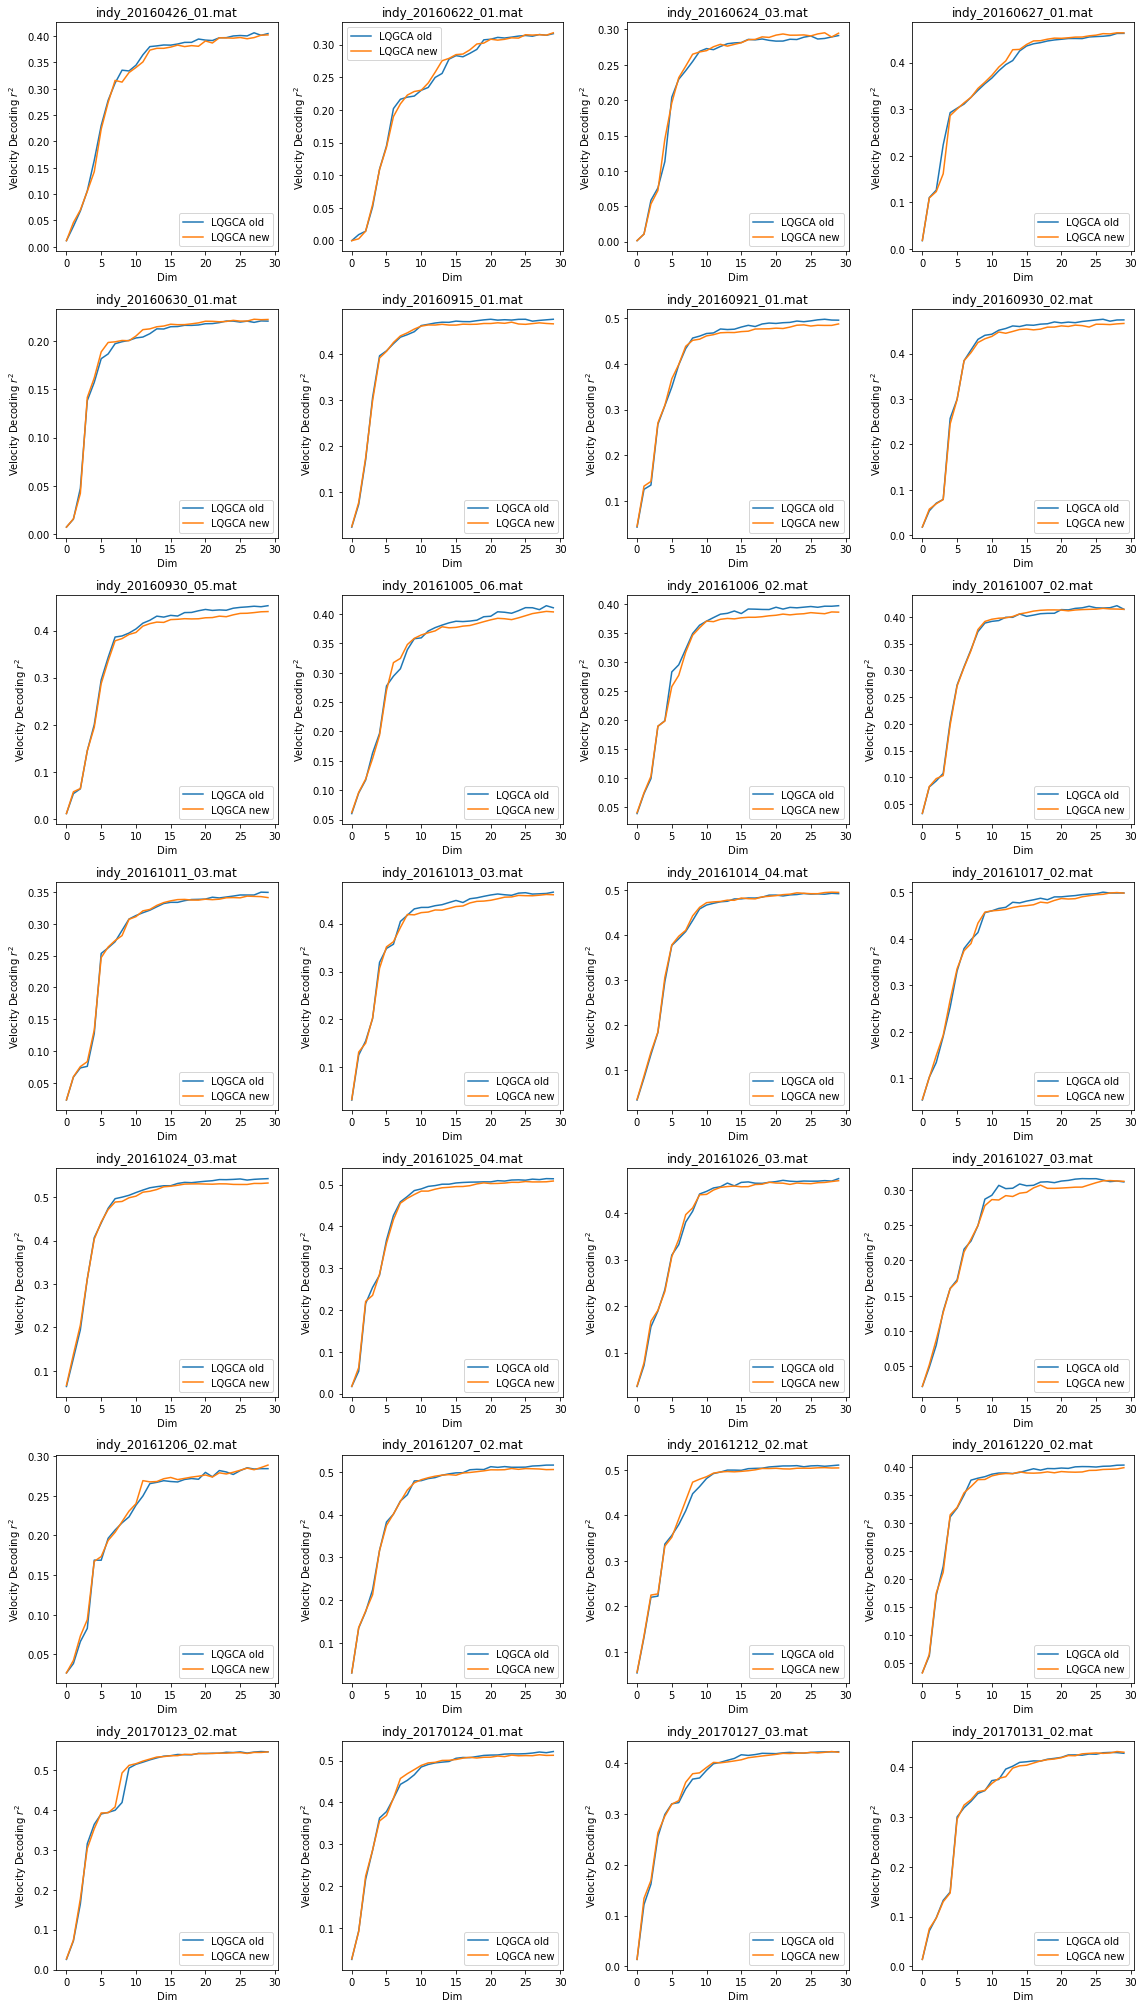

In [20]:
# Compare the new decoding results to the old ones
fig, ax = plt.subplots(7, 4, figsize=(16, 28))

for i in range(len(data_files)):
    a = ax[np.unravel_index(i, (7, 4))]
    
    # PCA
    #a.plot(np.mean(r2[i, :, 0, :, 1], axis=1))
    # DCA
    # a.plot(np.mean(r2[i, :, 1, :, 1], axis=1))
    # KCA causal
    #a.plot(np.mean(r2[i, :, 2, :, 1], axis=1))
    # KCA acausal
 #   a.plot(np.mean(r2[i, :, 3, :, 1], axis=1))
    # KCA balanced
#    a.plot(np.mean(r2[i, :, 4, :, 1], axis=1))

    # LQG trace
    a.plot(np.mean(r2[i, :, 5, :, 0], axis=1))

    # LQG frobenius 
#    a.plot(np.mean(r2[i, :, 6, :, 1], axis=1))

    # LQG logdetbut?
#    a.plot(np.mean(r2[i, :, 7, :, 1], axis=1))

    # LQG additive
#    a.plot(np.mean(r2[i, :, 8, :, 1], axis=1))
    
    a.plot(np.mean(r2fc[i, :, 1, 0, :, 0], axis=1))
    
    a.set_title(data_files[i])
    a.set_xlabel('Dim')
    a.set_ylabel('Velocity Decoding ' + r'$r^2$')

    a.legend(['LQGCA old', 'LQGCA new'])

fig.tight_layout()
# fig.savefig('LQGCA_DCA_comparison1.pdf', bbox_inches=0, pad_inches='tight')

In [55]:
scores.shape

(28, 30, 5)

In [56]:
scores2.shape

(28, 30, 2, 5)

In [ ]:
scores2[i, ]

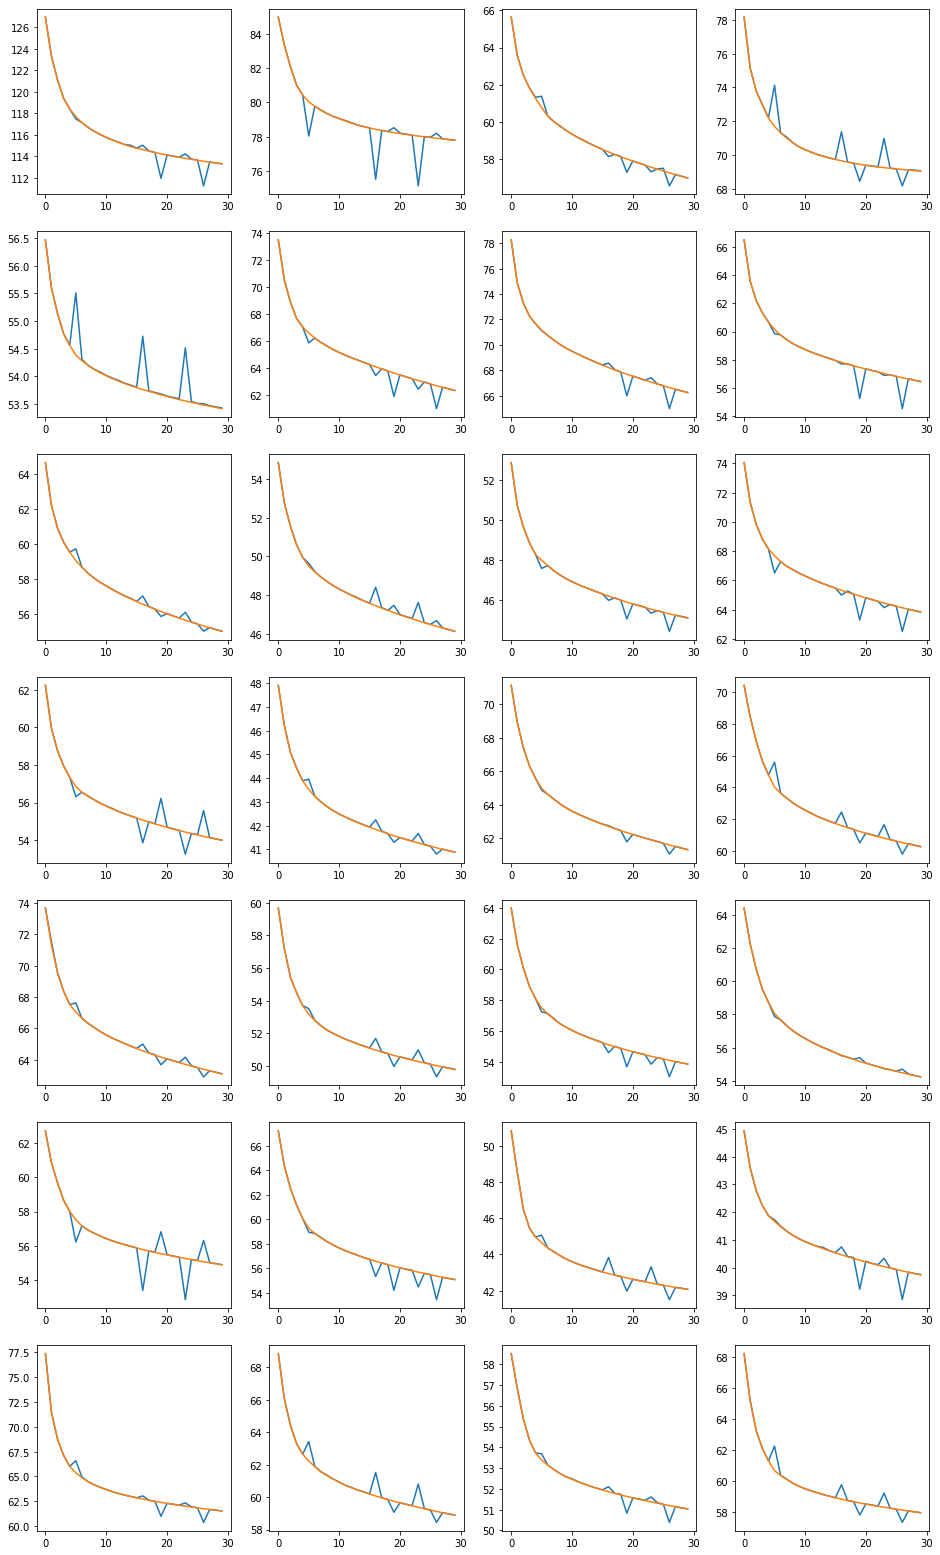

In [60]:
# What is the dispersion of scores across the different intiializations? 
fig, ax = plt.subplots(7, 4, figsize=(16, 28))

for i in range(len(data_files)):
    a = ax[np.unravel_index(i, (7, 4))]
    #a.plot(np.mean(scores[i, ...], axis=-1))
    #a.plot(np.mean(scores2[i, :, 0, :], axis=-1))
    a.plot(scores[i, :, 1])
    a.plot(scores2[i, :, 0, 1])

In [6]:
with open('/home/akumar/nse/neural_control/data/indy_norm_decoding.dat', 'rb') as f:
    rl = pickle.load(f)

In [7]:
sabes_df = pd.DataFrame(rl)

In [8]:
# For reference, the task_args:
task_args = [{'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'DCA', 'dimreduc_args': {'T':3, 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'KCA', 'dimreduc_args': {'T':3, 'causal_weights':(1, 0), 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'KCA', 'dimreduc_args': {'T':3, 'causal_weights':(0, 1), 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'KCA', 'dimreduc_args': {'T':3, 'causal_weights':(1, 1), 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'LQGCA', 'dimreduc_args': {'T':3, 'loss_type':'trace', 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'LQGCA', 'dimreduc_args': {'T':3, 'loss_type':'fro', 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'LQGCA', 'dimreduc_args': {'T':3, 'loss_type':'logdet', 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'LQGCA', 'dimreduc_args': {'T':3, 'loss_type':'additive', 'n_init':5}},
             {'dim_vals':np.arange(1, 31), 'n_folds':5, 'dimreduc_method':'PCA', 'dimreduc_args': {}}]


In [9]:
data_files = np.unique(sabes_df['data_file'].values)
dims = np.unique(sabes_df['dim'].values)
dr_args = [{'T':3, 'loss_type':'trace', 'n_init':5}, {'T':3, 'loss_type':'fro', 'n_init':5},
           {'T':3, 'loss_type':'additive50', 'n_init':5},{'T':3, 'loss_type':'additive25', 'n_init':5},
           {'T':3, 'loss_type':'additive75', 'n_init':5},{'T':4, 'loss_type':'trace', 'n_init':5},
           {'T':4, 'loss_type':'fro', 'n_init':5}, {'T':4, 'loss_type':'additive50', 'n_init':5},
           {'T':4, 'loss_type':'additive25', 'n_init':5},{'T':4, 'loss_type':'additive25', 'n_init':5}]

dec_args = [{'trainlag':4, 'testlag':4, 'decoding_window':5}]
r2fc = np.zeros((len(data_files), dims.size, len(dr_args), 1, 5, 3))
for k1,  dra in enumerate(dr_args):
    for k2, dec in enumerate(dec_args):
        df = apply_df_filters(sabes_df, dimreduc_args=dra, decoder_args=dec)    
        for i, data_file in tqdm(enumerate(data_files)):
            for j, dim in enumerate(dims):               
                for f in range(5):
                    dim_fold_df = apply_df_filters(df, data_file=data_file, dim=dim, fold_idx=f)
                    # Trace loss
                    assert(dim_fold_df.shape[0] == 1)
                    r2fc[i, j, k1, k2, f, :] = dim_fold_df.iloc[0]['r2']


28it [00:03,  7.52it/s]
28it [00:03,  7.61it/s]
28it [00:03,  7.55it/s]
28it [00:03,  7.78it/s]
28it [00:03,  7.62it/s]
28it [00:03,  7.59it/s]
28it [00:03,  7.66it/s]
28it [00:03,  7.71it/s]
28it [00:03,  7.61it/s]
28it [00:03,  7.51it/s]


In [14]:
# Grab PCA results
with open('/home/akumar/nse/neural_control/data/sabes_kca_decodign_df.dat', 'rb') as f:
    pca_decoding_df = pickle.load(f)

In [25]:
dims = np.unique(sabes_df['dim'].values)
sr2_vel_pca = np.zeros((28, 30, 5))
for i, data_file in enumerate(data_files):
    for j, dim in enumerate(dims):
        data_file = data_file.split('/')[-1]
        pca_df = apply_df_filters(pca_decoding_df, dim=dim, data_file=data_file, dr_method='PCA')        
        for k in range(pca_df.shape[0]):
            sr2_vel_pca[i, j, k] = pca_df.iloc[k]['r2'][1]

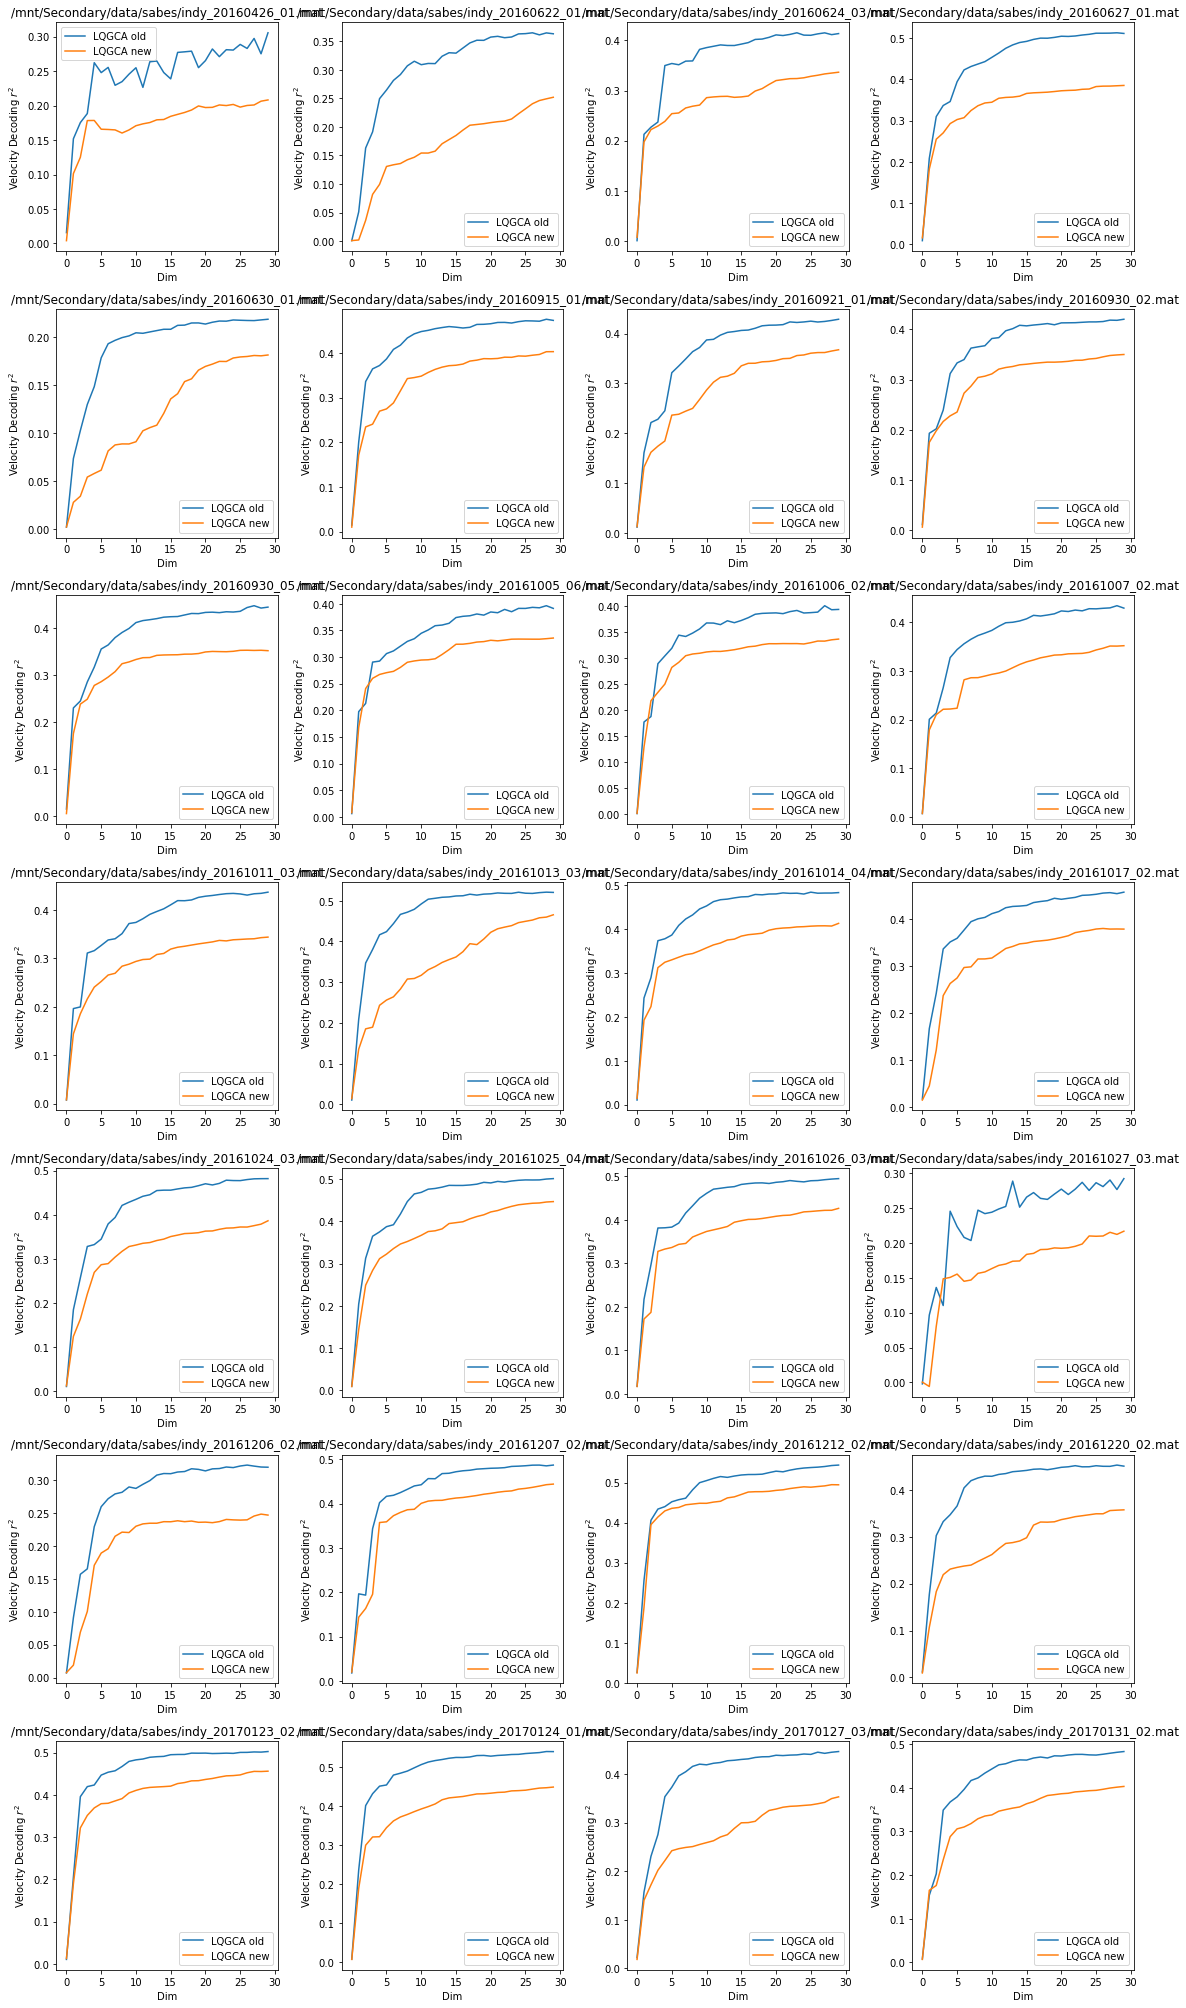

In [26]:
# Compare the new decoding results to the old ones
fig, ax = plt.subplots(7, 4, figsize=(16, 28))

for i in range(len(data_files)):
    a = ax[np.unravel_index(i, (7, 4))]
    
    # PCA
    #a.plot(np.mean(r2[i, :, 0, :, 1], axis=1))
    # DCA
    # a.plot(np.mean(r2[i, :, 1, :, 1], axis=1))
    # KCA causal
    #a.plot(np.mean(r2[i, :, 2, :, 1], axis=1))
    # KCA acausal
 #   a.plot(np.mean(r2[i, :, 3, :, 1], axis=1))
    # KCA balanced
#    a.plot(np.mean(r2[i, :, 4, :, 1], axis=1))

    # LQG frobenius 
#    a.plot(np.mean(r2[i, :, 6, :, 1], axis=1))

    # LQG logdetbut?
#    a.plot(np.mean(r2[i, :, 7, :, 1], axis=1))

    # LQG additive
#    a.plot(np.mean(r2[i, :, 8, :, 1], axis=1))
    
    a.plot(np.mean(r2fc[i, :, 0, 0, :, 1], axis=1))
    a.plot(np.mean(sr2_vel_pca[i, :, :], axis=1))

    a.set_title(data_files[i])
    a.set_xlabel('Dim')
    a.set_ylabel('Velocity Decoding ' + r'$r^2$')

    a.legend(['LQGCA old', 'LQGCA new'])

fig.tight_layout()
# fig.savefig('LQGCA_DCA_comparison1.pdf', bbox_inches=0, pad_inches='tight')

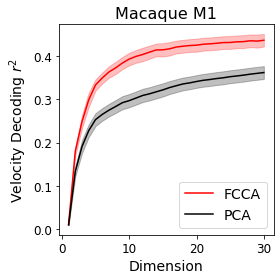

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# Average across folds and plot
# REINSERT OLS(5) IN HERE IF NEEDED

colors = ['black', 'red', '#781820', '#5563fa']
dim_vals =dims

# # DCA averaged over folds
# dca_r2 = np.mean(r2[:, :, 1, :, 1], axis=2)
# # KCA averaged over folds
# kca_r2 = np.mean(r2[:, :, 2, :, 1], axis=2)

# FCCA averaged over folds
fca_r2 = np.mean(r2fc[:, :, 0, 0, :, 1], axis=2)
# PCA
pca_r2 = np.mean(sr2_vel_pca, axis=-1)

# ax.fill_between(dim_vals, np.mean(dca_r2, axis=0) + np.std(dca_r2, axis=0)/np.sqrt(28),
#                 np.mean(dca_r2, axis=0) - np.std(dca_r2, axis=0)/np.sqrt(28), color=colors[0], alpha=0.25)
# ax.plot(dim_vals, np.mean(dca_r2, axis=0), color=colors[0])
# ax.fill_between(dim_vals, np.mean(kca_r2, axis=0) + np.std(kca_r2, axis=0)/np.sqrt(28),
#                 np.mean(kca_r2, axis=0) - np.std(kca_r2, axis=0)/np.sqrt(28), color=colors[1], alpha=0.25)
# ax.plot(dim_vals, np.mean(kca_r2, axis=0), color=colors[1])
ax.fill_between(dim_vals, np.mean(fca_r2, axis=0) + np.std(fca_r2, axis=0)/np.sqrt(28),
                np.mean(fca_r2, axis=0) - np.std(fca_r2, axis=0)/np.sqrt(28), color=colors[1], alpha=0.25)
ax.plot(dim_vals, np.mean(fca_r2, axis=0), color=colors[1])

ax.fill_between(dim_vals, np.mean(pca_r2, axis=0) + np.std(pca_r2, axis=0)/np.sqrt(28),
                np.mean(pca_r2, axis=0) - np.std(pca_r2, axis=0)/np.sqrt(28), color=colors[0], alpha=0.25)
ax.plot(dim_vals, np.mean(pca_r2, axis=0), color=colors[0])

ax.set_xlabel('Dimension', fontsize=14)
ax.set_ylabel('Velocity Decoding ' + r'$r^2$', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.legend(['FCCA', 'PCA'], loc='lower right', fontsize=14)
ax.set_title('Macaque M1', fontsize=16)
fig.tight_layout()
# fig.savefig('/home/akumar/nse/neural_control/figs/final/indy_vel_decoding.pdf', bbox_inches='tight', pad_inches=0)